In [125]:
# ROC 20250408    重要不要删   用roc概率值来计算TP FN TN等。计算所有疾病的AUC，包括癌症，保存分析数据，benchmark，只保留部分需要的特征，并且采样阴性和恶阳性相等做预测 
import shap
import torch
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import os
from sklearn.metrics import roc_curve
import re

data_dir = Path("../data/UKB")
data_df = pd.read_csv(data_dir / "output_data.csv", index_col=0)

# 设置随机种子
np.random.seed(42)  



meanings = [
    "hypertension",
    #"high cholesterol",
    "asthma",
    #"osteoarthritis",
    #"hayfever/allergic rhinitis",
    #"depression",
    #"hypothyroidism/myxoedema",
    #"gastro-oesophageal reflux (gord) / gastric reflux",
    "diabetes"
]

meanings = [
    "hypertension",
    "high cholesterol",
    "asthma",
    "osteoarthritis",
    "hayfever/allergic rhinitis",
    "depression",
    "hypothyroidism/myxoedema",
    "gastro-oesophageal reflux (gord) / gastric reflux",
    "diabetes"
]

meanings = traits_df[(traits_df['field_id'].isin([20002, 20001]))]["meaning"].values
meanings = ["menopausal symptoms / menopause",]
meanings = [
    "prostate cancer",
    "malignant melanoma",
    "cin/pre-cancer cells cervix",
    "basal cell carcinoma",
    "diabetes",
    "heart attack/myocardial infarction",
    "malabsorption/coeliac disease",
    "angina",
    "cervical cancer",
    "measles / morbillivirus",
    "gout",
    "mumps / epidemic parotitis",
    "diabetic eye disease"
]


meanings = [
    "malabsorption/coeliac disease",
    "cin/pre-cancer cells cervix",
    "inguinal hernia",
    "heart attack/myocardial infarction",
    "prostate cancer",
    "cervical cancer",
    "gout",
    "diabetes",
    "breast cancer",
    "malignant melanoma",
    "migraine",
    "basal cell carcinoma",
    "high cholesterol",
    "hypothyroidism/myxoedema"
]
meanings = traits_df[(traits_df['field_id'].isin([20002, 20001]))]["meaning"].values
#meanings = ["menopausal symptoms / menopause",]
# 初始化结果 DataFrame
out_f1_df = pd.DataFrame(columns=['trait', 'value', 'meaning', 'token_id', 
                                  'TP', 'FN', 'FP', 'TN', 'F1', 'Total'])
#embedding_df = pd.DataFrame(columns=['Prediction', 'Target', 'Embedding'])

    
# 过滤掉不需要的特征

keep_col = ['Socio-demographics',  "Diet and alcohol summary", "Lifestyle", "Education and employment",  "Physical measure summary"]

keep_col = ['Self-reported medical conditions']
keep_col = ['Physical measure summary', 'Primary demographics', 'Early life',
        'Cognitive function summary',
       'Education and employment', 'Diet and alcohol summary',
       'Mental health', 'Brain MRI',
       'Main abdominal MRI fields likely to be of interest to researchers.',
       'Heart MRI', 'Geographical and location', 'Genomics',
       'Linked health outcomes', 'Socio-demographics', 'Lifestyle',
       'Family history', 'Biomarkers']

keep_col = ["Diet and alcohol summary", "Lifestyle", "Education and employment" ,
            'Family history','Socio-demographics','Physical measure summary',  ]

keep_col = traits_df['category_name']
keep_col = ["Diet and alcohol summary", "Lifestyle" ]


keep_traits_df = traits_df[((traits_df['category_name'].isin(keep_col)) |
                            traits_df['field_id'].isin([20002, 20001]))]

test_df = data_df.iloc[:450000, :]

# 筛选出想保留的特征类别
test_df = test_df.fillna(vocab["<pad>"])
# 删除完全是 pad_value 的列
#test_df = test_df.loc[:, ~(test_df == pad_value).all(axis=0)]
#去除空值超过50%的行. 空值越多越不好
#pad_ratio = (test_df == pad_value).mean(axis=1)  
#test_df = test_df[pad_ratio <= 0.72]  
keep_col_idx = [v  for v in test_df.columns if int(re.search(r'd(\d+)-', v).group(1)) in keep_traits_df['field_id'].values]
test_df = test_df.loc[:, keep_col_idx]



# 将 meanings 转换为字典索引以提高效率
meaning_to_traits = {meaning: traits_df[(traits_df['meaning'] == meaning) & 
                     traits_df['field_id'].isin([20002, 20001])] for meaning in meanings}
del meaning_to_traits['myasthenia gravis']  # 这个疾病出现两次，在包含这个时候要注意  批量运行时候要取消注释
# 初始化结果 DataFrame
out_f1_df = pd.DataFrame(columns=['trait', 'value', 'meaning', 'token_id', 
                                  'TP', 'FN', 'FP', 'TN', 'F1', 'Accuracy', 'Precision', 'Recall', 'AUC'])

for meaning, sel_traits_df in meaning_to_traits.items():
    single_auc_file = f'APP3.disease_AUC.{meaning.replace("/", "_")}.results.csv'
    if os.path.exists(single_auc_file):
        print(f'continue, existing file: {single_auc_file}')
        # 假设保存的文件里存储了new_row信息
        single_auc = pd.read_csv(single_auc_file)
        print(single_auc)
        out_f1_df = pd.concat([out_f1_df, single_auc], ignore_index=True)
        continue
    diseases_series = sel_traits_df['token_id']
    """
    # 判断有病的患者行
    contains_disease_indices = np.where(np.any(test_df.values == diseases_df[diseases_df % 2 == 0].values, axis=1))[0]
    if len(contains_disease_indices) <100:
        continue
    
    # 判断没病的患者行
    not_contains_disease_indices = np.where(np.any(test_df.values == diseases_df[diseases_df % 2 == 1].values, axis=1))[0]
    """
    
    # 判断有病的患者行
    contains_even = np.any(np.isin(test_df.values, diseases_series[diseases_series % 2 == 0].iloc[0]), axis=1)
    contains_disease_indices = np.where(contains_even)[0]
    if len(contains_disease_indices) <100:
        continue
    
    # 判断没病的患者行
    not_contains_even = np.any(np.isin(test_df.values, diseases_series[diseases_series % 2 == 1].iloc[0]), axis=1)
    not_contains_disease_indices = np.where(not_contains_even)[0]
    
    
    # 随机采样阴性样本
    sampled_not_contains_disease_indices = np.random.choice(
        not_contains_disease_indices, size=contains_disease_indices.shape[0], replace=False
    )
    
    # 合并有病和采样的无病样本索引
    selected_indices = np.concatenate((contains_disease_indices, sampled_not_contains_disease_indices))
    
  
    adata = sc.AnnData(test_df.values[selected_indices].copy())   # 我们的模型数据预测， 不需要 target标注

    
    ## 保存数据给其他软件做bench mark
    test_df['target'] = 44287
    # 将 diseases_series.values 转换为集合以加速匹配
    disease_set = set(diseases_series.values)
    # 替换 test_df 中的值，如果值在 disease_set 中，则替换为 44287
    test_df = test_df.map(lambda x: 44287 if x in disease_set else x)
    test_df.loc[test_df.index[contains_disease_indices], 'target'] = 1
    test_df.loc[test_df.index[not_contains_disease_indices], 'target'] = 0
    out_for_other_soft_test_df = test_df.loc[test_df.index[selected_indices], :]
    ##out_for_other_soft_test_df.to_csv(f'APP3.benchmark_data_{meaning.replace("/", "_")}.csv')  # 临时注释
    print(f'正在分析疾病{meaning}， 共阳性{len(contains_disease_indices) }人，采样阴性{len(sampled_not_contains_disease_indices) }人')
    """   """

    # 清空 GPU 缓存
    torch.cuda.empty_cache()

    device = 'cuda:3'
    
    adataX = adata.X
    # 使用该函数对 all_counts 进行替换，并覆盖原数组
    #print('adataX=', adataX.shape)
    trait_ids = vectorized_replace(adataX)
    
    input_layer_key = None
    individualtypes_labels = np.array(range(adata.shape[0]))
    train_data = adataX
    
    max_seq_len = 3000
    
    tokenized_train = tokenize_and_pad_batch(
        train_data,
        trait_ids,
        max_len=max_seq_len,
        vocab=vocab,
        pad_token=pad_token,
        pad_value=pad_value,
        append_cls=False,  # append <cls> token at the beginning
        include_zero_trait=True,
    )
    
    input_trait_ids_train = tokenized_train["traits"].to(device)
    values = tokenized_train["values"].to(device)
    #print('values=', values, values.shape)

    input_values_train = values.clone()

    # 用 diseases 和 pad_traits 进行掩码
    diseases_values_tensor = torch.tensor(diseases_series.values, dtype=input_values_train.dtype, device=values.device)
    diseases_token_id_tensor = torch.tensor(traits_df[traits_df['field_id'].isin([20002, 20001])]['token_id'].values, dtype=input_values_train.dtype, device=values.device)
    mask_value_tensor = torch.tensor(mask_value, dtype=input_values_train.dtype, device=values.device)
    pad_value_tensor = torch.tensor(pad_value, dtype=input_values_train.dtype, device=values.device)

    # 把疾病部分mask住，把其余不需要作为输入的pad住
    input_values_train = torch.where(torch.isin(input_values_train, diseases_values_tensor), mask_value_tensor, input_values_train)
    input_values_train = torch.where(torch.isin(input_values_train, diseases_token_id_tensor), pad_value_tensor, input_values_train)

    # 生成数据集和 DataLoader  #####
    dataset = SeqDataset({"trait_ids": input_trait_ids_train, "values": input_values_train,
                          "target_values": values,
                          "batch_labels": torch.zeros(input_trait_ids_train.shape[0]), 
                          "individualtype_labels": torch.zeros(input_trait_ids_train.shape[0])})
    
    del diseases_values_tensor, input_values_train  ######### 

    
    train_loader = DataLoader(dataset, batch_size=20, shuffle=False, drop_last=False, num_workers=0, pin_memory=False)
    predictions, targets, predictions_roc = [], [], []
    model.to(device)
    torch.cuda.empty_cache()
    
    # 处理每个批次
    
    for batch_data in train_loader:
        batch_data = {k: v.to(device) for k, v in batch_data.items()}
        
        with torch.no_grad():
            transformer_output = model._encode(batch_data["trait_ids"], batch_data["values"], 
                                               batch_data["trait_ids"].eq(vocab[pad_token]), batch_data["batch_labels"])
            mlm_output = model.combine_decoder(transformer_output)
            decoded_embs = mlm_output[np.isin(batch_data["target_values"].cpu().numpy(), diseases_series.values)]

            # 提取预测值和目标值
            # predictions += [diseases_series.values[i] for i in list(torch.argmax(decoded_embs[:, diseases_series.values ], dim=-1).cpu().numpy())]
            predictions += list(torch.argmax(decoded_embs, dim=-1).cpu().numpy())
            targets += list(batch_data["target_values"][np.isin(batch_data["target_values"].cpu().numpy(), diseases_series.values)].cpu().numpy())

 
            # 提取预测值对应的概率值，ROC会设置不同阈值作为正例，来画ROC曲线
            predictions_roc += list(decoded_embs[:, diseases_series[diseases_series % 2 == 0].values ].cpu().numpy())
            
            # 保存 embedding 信息
            zipped_data_list = list(zip(
                batch_data["target_values"][np.isin(batch_data["target_values"].cpu().numpy(), diseases_series.values)].cpu().numpy(),
                torch.argmax(decoded_embs, dim=-1).cpu().numpy(),
                transformer_output[np.isin(batch_data["target_values"].cpu().numpy(), diseases_series.values)].cpu().numpy()
            ))
            #d = pd.DataFrame(zipped_data_list, columns=['Target', 'Prediction', 'Embedding'])
            #embedding_df = pd.concat([embedding_df, d], ignore_index=True)
    
    # 计算性能指标
    targets, predictions = np.array(targets), np.array(predictions)
    sel_target_tokens = sel_traits_df['token_id'].values
    targets_int = targets[np.isin(targets, sel_target_tokens)].astype(int)
    predictions_int = predictions[np.isin(predictions, sel_target_tokens)].astype(int)
    
    binary_mapping = {sel_target_tokens[0]: 1, sel_target_tokens[1]: 0} if sel_target_tokens[0] % 2 == 0 else {sel_target_tokens[1]: 1, sel_target_tokens[0]: 0}
    targets_binary = np.array([binary_mapping[x] for x in targets_int])
    predictions_binary = np.array([binary_mapping[x] for x in predictions_int])


    # You can choose a threshold for classification (e.g., 0.5 or another value based on the ROC curve)
    #threshold = 0.5
    # 20250408 用概率值判断结果不错
    predictions_binary = (np.array(predictions_roc).flatten() >= np.array(predictions_roc).flatten().mean()).astype(int)
    
    cm_binary = confusion_matrix(targets_binary, predictions_binary, labels=[1, 0])
    TP, FN, FP, TN = cm_binary.ravel()
    f1, accuracy, precision, recall, auc = f1_score(
        targets_binary, predictions_binary), accuracy_score(
        targets_binary, predictions_binary),     precision_score(
        targets_binary, predictions_binary), recall_score(
        targets_binary, predictions_binary), roc_auc_score(
        targets_binary, predictions_roc)
    
    # 保存结果到 DataFrame
    single_auc = pd.DataFrame([{
        'trait': sel_traits_df['trait'].values[0],
        'value': sel_traits_df['value'].values[0],
        'meaning': meaning,
        'token_id': sel_target_tokens[0],
        'TP': TP, 'FN': FN, 'FP': FP, 'TN': TN, 'F1': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'AUC': auc
    }])
    print(single_auc)
    single_auc.to_csv(single_auc_file, index=False)
    out_f1_df = pd.concat([out_f1_df, single_auc], ignore_index=True)
    
    safe_meaning = re.sub(r'[^\w]', '', meaning)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_binary, annot=True, cmap='YlGnBu')
    plt.title(meaning)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig(f'APP3.panel.3.confusion_matrix.{safe_meaning}.svg', dpi=300, bbox_inches='tight')
    plt.close() 

    # 绘制 ROC 曲线
    fpr, tpr, _ = roc_curve(targets_binary, predictions_roc)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f'ROC Curve for {meaning}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig(f'APP3.B.ROC_Curve_{safe_meaning}.svg', dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()  # 防止内存泄漏
    """  """
    

# 保存结果
out_f1_df.to_csv('APP3.disease_AUC_results.csv', index=False)
#embedding_df.to_csv('APP3.disease_embeddings.csv', index=False)
print("Results saved to 'APP3.disease_AUC_results.csv'")
print(out_f1_df[['meaning', 'AUC']])

continue, existing file: APP3.disease_AUC.lung cancer.results.csv
                            trait  value      meaning  token_id   TP  FN  FP  \
0  c1003_t20001-1001_i2_v22_s2_e3   1001  lung cancer      1302  182  92  97   

    TN        F1  Accuracy  Precision    Recall       AUC  
0  177  0.658228  0.655109    0.65233  0.664234  0.723853  
continue, existing file: APP3.disease_AUC.breast cancer.results.csv
                            trait  value        meaning  token_id    TP    FN  \
0  c1003_t20001-1002_i2_v22_s2_e3   1002  breast cancer      1304  7607  2516   

     FP    TN       F1  Accuracy  Precision    Recall       AUC  
0  4612  5511  0.68096   0.64793   0.622555  0.751457  0.753952  
continue, existing file: APP3.disease_AUC.skin cancer.results.csv
                            trait  value      meaning  token_id   TP   FN  \
0  c1003_t20001-1003_i2_v22_s2_e3   1003  skin cancer      1306  761  553   

    FP   TN        F1  Accuracy  Precision    Recall       AUC  
0  6

/tmp/ipykernel_744481/4278832990.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out_f1_df = pd.concat([out_f1_df, single_auc], ignore_index=True)


continue, existing file: APP3.disease_AUC.larynx_throat cancer.results.csv
                            trait  value               meaning  token_id   TP  \
0  c1003_t20001-1006_i2_v22_s2_e3   1006  larynx/throat cancer      1312  241   

   FN  FP   TN        F1  Accuracy  Precision    Recall       AUC  
0  87  94  234  0.726998  0.724085   0.719403  0.734756  0.803028  
continue, existing file: APP3.disease_AUC.tongue cancer.results.csv
                            trait  value        meaning  token_id  TP  FN  FP  \
0  c1003_t20001-1011_i2_v22_s2_e3   1011  tongue cancer      1322  89  49  53   

   TN        F1  Accuracy  Precision    Recall       AUC  
0  85  0.635714  0.630435   0.626761  0.644928  0.690664  
continue, existing file: APP3.disease_AUC.oesophageal cancer.results.csv
                            trait  value             meaning  token_id   TP  \
0  c1003_t20001-1017_i2_v22_s2_e3   1017  oesophageal cancer      1330  140   

   FN  FP   TN        F1  Accuracy  Precision

scGPT - INFO - Resume model from save/dev_UKB-Sep10-00-11/APP3_twotraits_model.pt, the model args will override the config save/dev_UKB-Sep10-00-11/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Sep10-00-11/APP3_twotraits_model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


                      meanning percentile  positives  negatives  total  \
0  malabsorptioncoeliacdisease         Q1         15      12226  12241   
1  malabsorptioncoeliacdisease         Q2         27      12214  12241   
2  malabsorptioncoeliacdisease         Q3         39      12202  12241   
3  malabsorptioncoeliacdisease         Q4        245      11996  12241   

          OR       PPV       p_value  
0   1.000000  0.001225  1.000000e+00  
1   1.801768  0.002206  8.935788e-02  
2   2.605114  0.003186  1.728167e-03  
3  16.646493  0.020015  3.001080e-46  
Results saved to APP3.E.OR.malabsorptioncoeliacdisease.csv


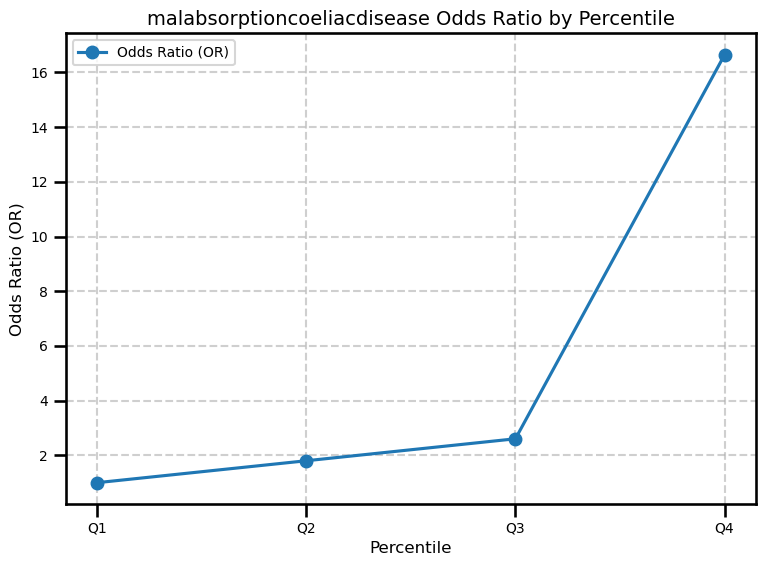

                  meanning percentile  positives  negatives  total        OR  \
0  cinprecancercellscervix         Q1         46      12195  12241  1.000000   
1  cinprecancercellscervix         Q2        119      12122  12241  2.602535   
2  cinprecancercellscervix         Q3        122      12119  12241  2.668806   
3  cinprecancercellscervix         Q4        219      12022  12241  4.829380   

        PPV       p_value  
0  0.003758  1.000000e+00  
1  0.009721  1.863945e-08  
2  0.009967  6.385629e-09  
3  0.017891  2.316365e-26  
Results saved to APP3.E.OR.cinprecancercellscervix.csv


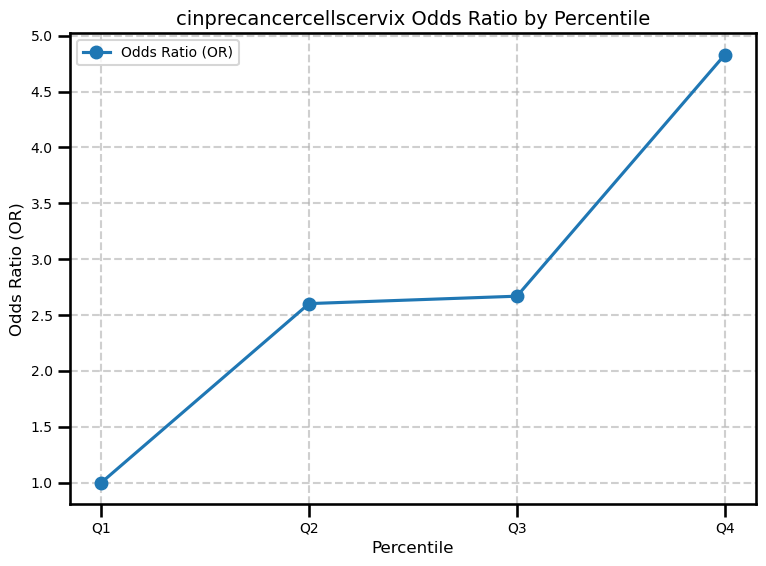

         meanning percentile  positives  negatives  total        OR       PPV  \
0  inguinalhernia         Q1        179      12062  12241  1.000000  0.014623   
1  inguinalhernia         Q2        301      11940  12241  1.698746  0.024589   
2  inguinalhernia         Q3        266      11975  12241  1.496830  0.021730   
3  inguinalhernia         Q4        404      11837  12241  2.299884  0.033004   

        p_value  
0  1.000000e+00  
1  2.435517e-08  
2  3.882635e-05  
3  6.022568e-21  
Results saved to APP3.E.OR.inguinalhernia.csv


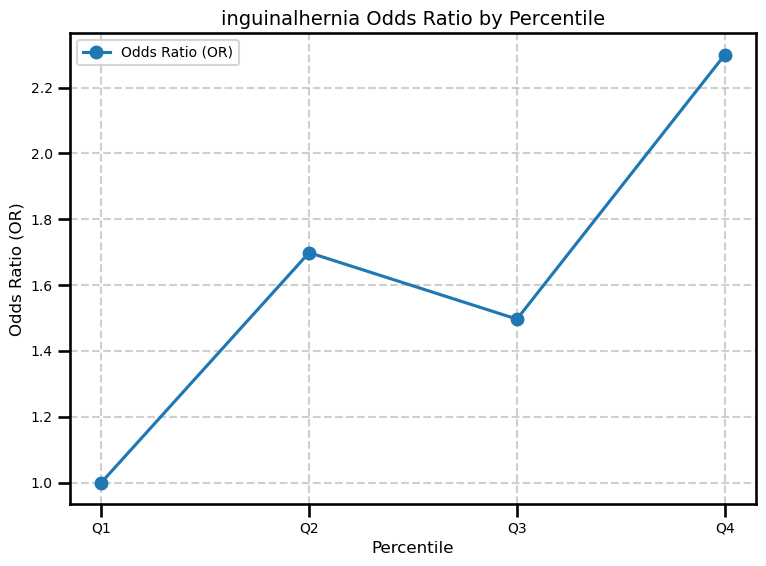

                          meanning percentile  positives  negatives  total  \
0  heartattackmyocardialinfarction         Q1         62      12179  12241   
1  heartattackmyocardialinfarction         Q2        131      12110  12241   
2  heartattackmyocardialinfarction         Q3        233      12008  12241   
3  heartattackmyocardialinfarction         Q4        631      11610  12241   

          OR       PPV        p_value  
0   1.000000  0.005065   1.000000e+00  
1   2.124942  0.010702   8.916600e-07  
2   3.811581  0.019034   2.327913e-23  
3  10.676209  0.051548  3.339397e-106  
Results saved to APP3.E.OR.heartattackmyocardialinfarction.csv


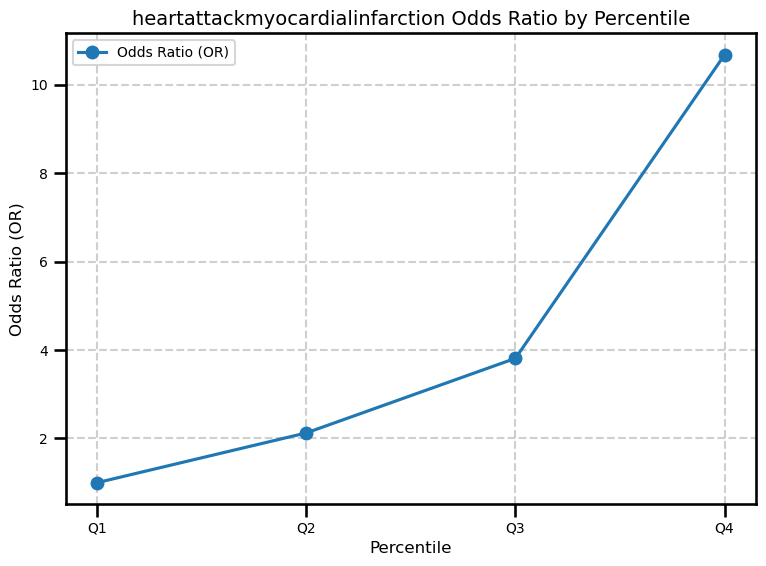

         meanning percentile  positives  negatives  total         OR  \
0  prostatecancer         Q1         29      12212  12241   1.000000   
1  prostatecancer         Q2        122      12119  12241   4.239180   
2  prostatecancer         Q3        352      11889  12241  12.467694   
3  prostatecancer         Q4        475      11766  12241  17.000182   

        PPV       p_value  
0  0.002369  1.000000e+00  
1  0.009967  5.910484e-14  
2  0.028756  4.484524e-62  
3  0.038804  3.070802e-89  
Results saved to APP3.E.OR.prostatecancer.csv


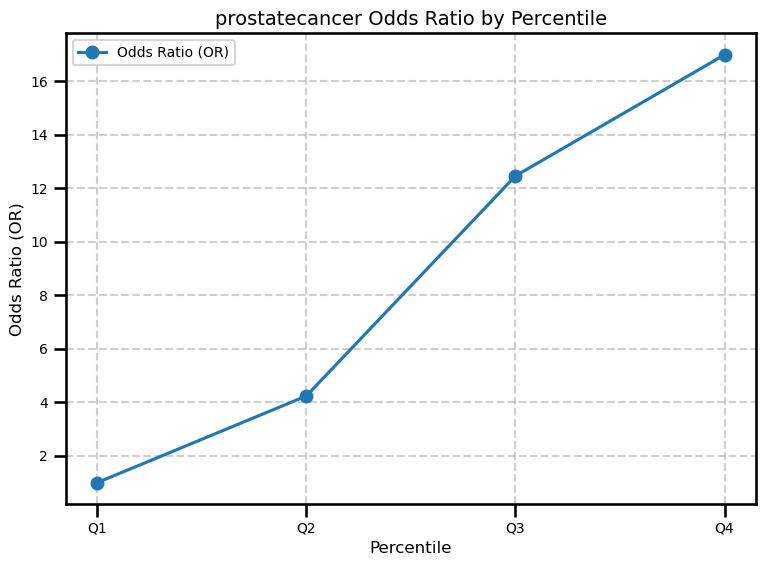

         meanning percentile  positives  negatives  total        OR       PPV  \
0  cervicalcancer         Q1         10      12231  12241  1.000000  0.000817   
1  cervicalcancer         Q2         28      12213  12241  2.804127  0.002287   
2  cervicalcancer         Q3         47      12194  12241  4.714261  0.003840   
3  cervicalcancer         Q4         95      12146  12241  9.566483  0.007761   

        p_value  
0  1.000000e+00  
1  5.781784e-03  
2  1.807127e-06  
3  2.118172e-16  
Results saved to APP3.E.OR.cervicalcancer.csv


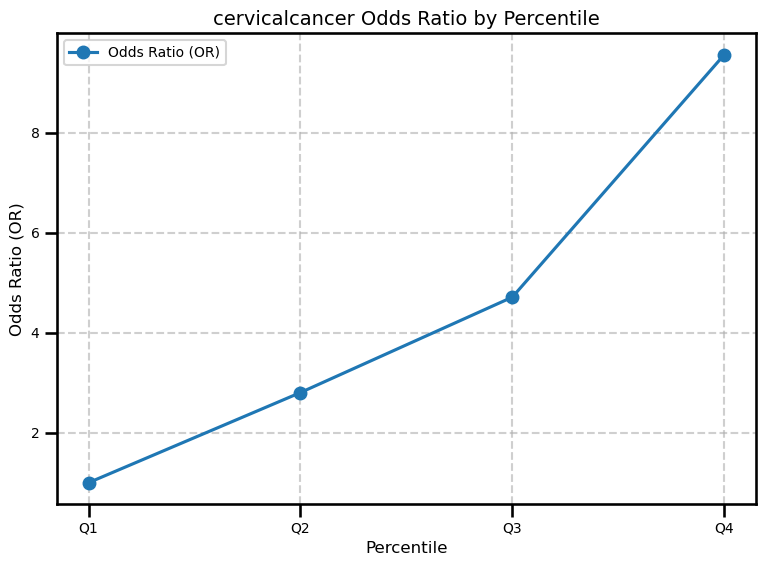

  meanning percentile  positives  negatives  total         OR       PPV  \
0     gout         Q1         41      12200  12241   1.000000  0.003349   
1     gout         Q2        104      12137  12241   2.549752  0.008496   
2     gout         Q3        273      11968  12241   6.787612  0.022302   
3     gout         Q4        680      11561  12241  17.502073  0.055551   

         p_value  
0   1.000000e+00  
1   2.415529e-07  
2   2.512856e-39  
3  1.612283e-128  
Results saved to APP3.E.OR.gout.csv


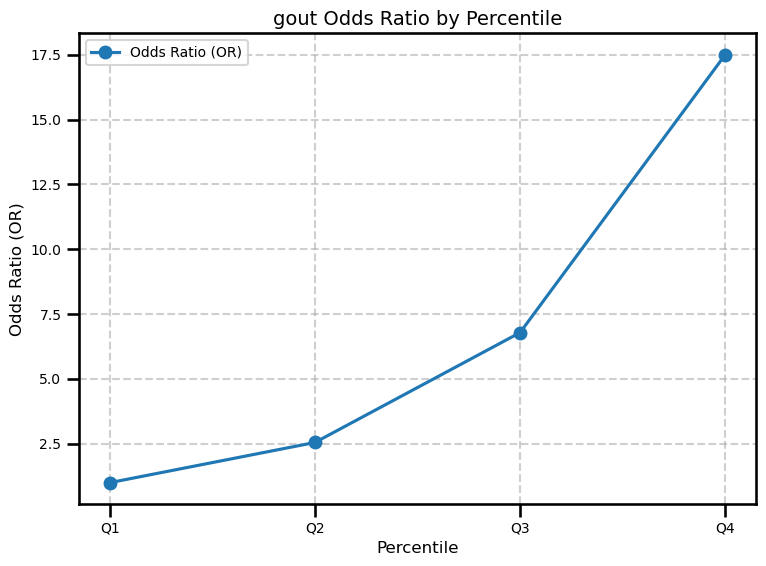

   meanning percentile  positives  negatives  total         OR       PPV  \
0  diabetes         Q1        112      12129  12241   1.000000  0.009150   
1  diabetes         Q2        227      12014  12241   2.046186  0.018544   
2  diabetes         Q3        376      11865  12241   3.431840  0.030716   
3  diabetes         Q4       1309      10932  12241  12.967224  0.106936   

         p_value  
0   1.000000e+00  
1   4.519283e-10  
2   2.597102e-33  
3  2.147283e-234  
Results saved to APP3.E.OR.diabetes.csv


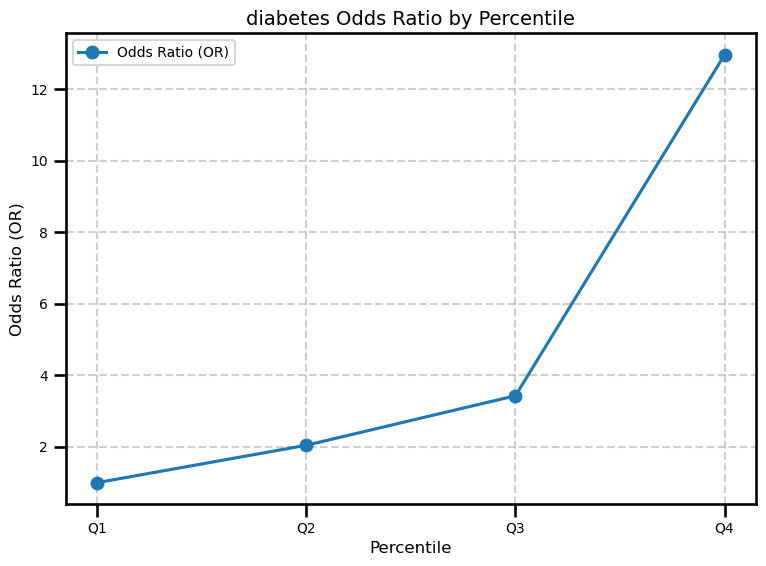

       meanning percentile  positives  negatives  total         OR       PPV  \
0  breastcancer         Q1         41      12200  12241   1.000000  0.003349   
1  breastcancer         Q2        181      12060  12241   4.465882  0.014786   
2  breastcancer         Q3        470      11771  12241  11.881205  0.038396   
3  breastcancer         Q4        677      11564  12241  17.420337  0.055306   

         p_value  
0   1.000000e+00  
1   7.140297e-21  
2   1.307018e-81  
3  7.704512e-128  
Results saved to APP3.E.OR.breastcancer.csv


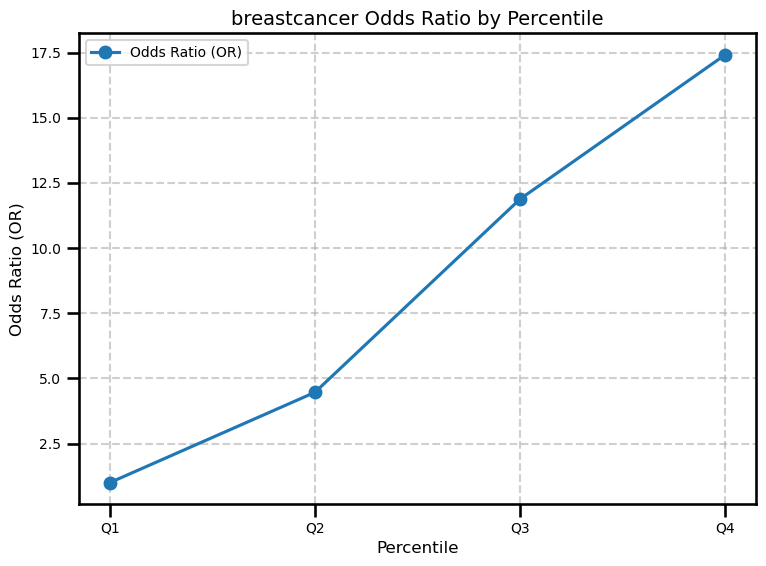

            meanning percentile  positives  negatives  total        OR  \
0  malignantmelanoma         Q1        121      12120  12241  1.000000   
1  malignantmelanoma         Q2        110      12131  12241  0.908267   
2  malignantmelanoma         Q3        177      12064  12241  1.469600   
3  malignantmelanoma         Q4        189      12052  12241  1.570797   

        PPV   p_value  
0  0.009885  1.000000  
1  0.008986  0.508562  
2  0.014460  0.001348  
3  0.015440  0.000128  
Results saved to APP3.E.OR.malignantmelanoma.csv


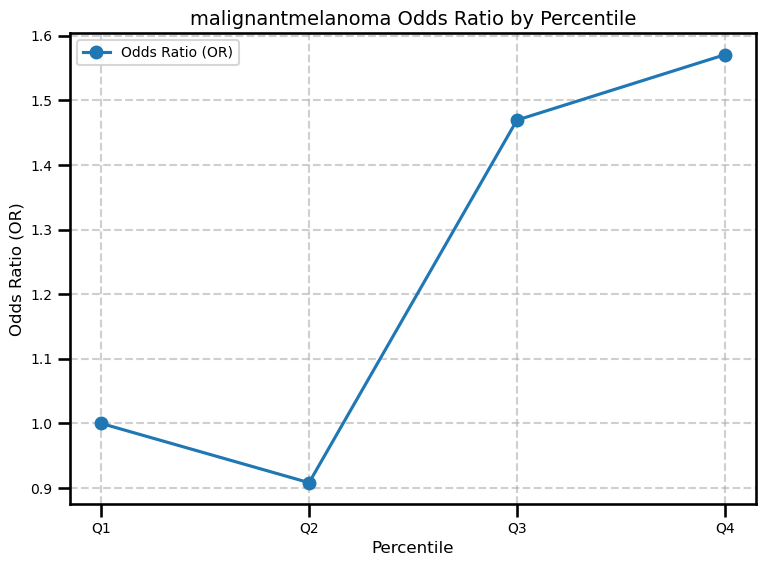

   meanning percentile  positives  negatives  total        OR       PPV  \
0  migraine         Q1        413      11828  12241  1.000000  0.033739   
1  migraine         Q2        720      11521  12241  1.789796  0.058819   
2  migraine         Q3        851      11390  12241  2.139770  0.069520   
3  migraine         Q4       1110      11131  12241  2.855946  0.090679   

        p_value  
0  1.000000e+00  
1  1.292306e-20  
2  1.602580e-36  
3  9.693240e-76  
Results saved to APP3.E.OR.migraine.csv


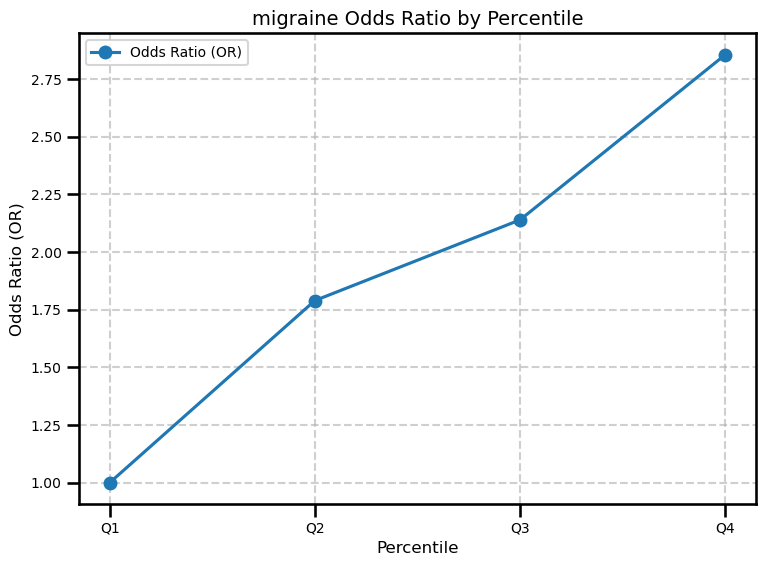

             meanning percentile  positives  negatives  total        OR  \
0  basalcellcarcinoma         Q1        469      11772  12241  1.000000   
1  basalcellcarcinoma         Q2        326      11915  12241  0.686754   
2  basalcellcarcinoma         Q3        309      11932  12241  0.650014   
3  basalcellcarcinoma         Q4        288      11953  12241  0.604774   

        PPV       p_value  
0  0.038314  1.000000e+00  
1  0.026632  3.054739e-07  
2  0.025243  6.904993e-09  
3  0.023527  3.016487e-11  
Results saved to APP3.E.OR.basalcellcarcinoma.csv


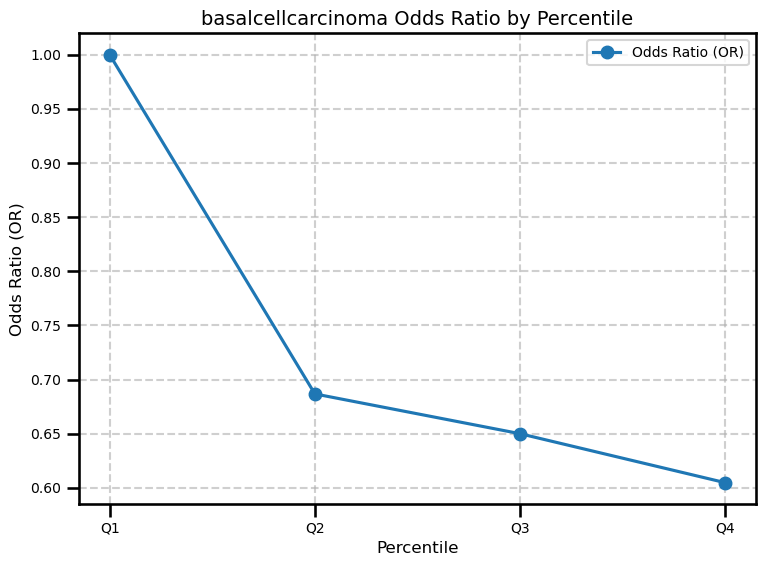

          meanning percentile  positives  negatives  total        OR  \
0  highcholesterol         Q1       1015      11226  12241  1.000000   
1  highcholesterol         Q2       1730      10511  12241  1.820376   
2  highcholesterol         Q3       2657       9584  12241  3.066223   
3  highcholesterol         Q4       4205       8036  12241  5.787421   

        PPV        p_value  
0  0.082918   1.000000e+00  
1  0.141328   2.083259e-47  
2  0.217057  1.224169e-189  
3  0.343518   0.000000e+00  
Results saved to APP3.E.OR.highcholesterol.csv


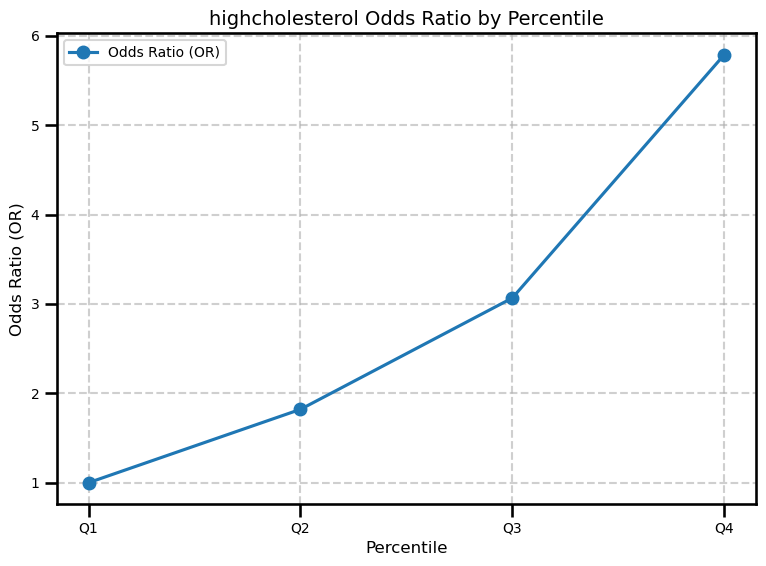

                  meanning percentile  positives  negatives  total        OR  \
0  hypothyroidismmyxoedema         Q1        263      11978  12241  1.000000   
1  hypothyroidismmyxoedema         Q2        596      11645  12241  2.330963   
2  hypothyroidismmyxoedema         Q3        922      11319  12241  3.709808   
3  hypothyroidismmyxoedema         Q4       1181      11060  12241  4.863213   

        PPV        p_value  
0  0.021485   1.000000e+00  
1  0.048689   9.120729e-31  
2  0.075321   1.713588e-85  
3  0.096479  1.341327e-136  
Results saved to APP3.E.OR.hypothyroidismmyxoedema.csv


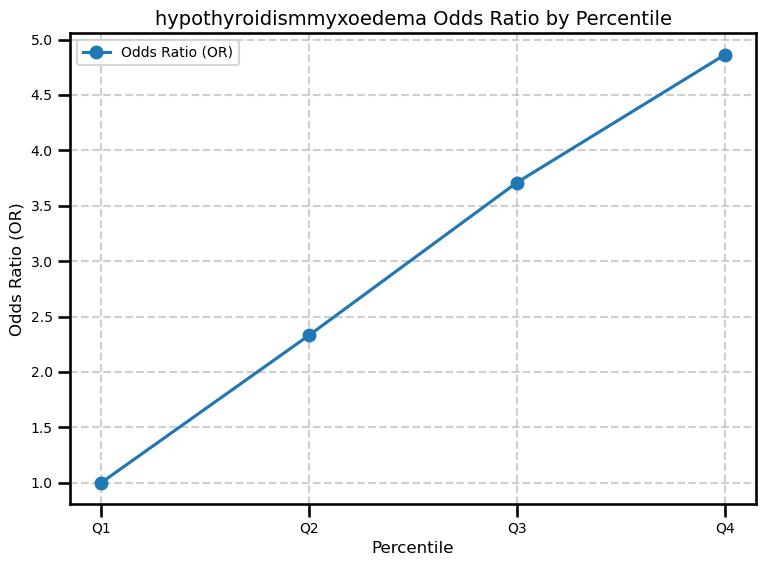

In [379]:
# 不要删20241207 APP3-E纵向的UKB假阳性验证，验证假阳样本后续发病情况. 使用概率值，并根据概率分层
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import re
import scanpy as sc
from pathlib import Path
import sys
sys.path.insert(0, "../")
from scgpt.tokenizer.trait_tokenizer import ValueVocab
from scgpt.model import TransformerModel
import pandas as pd
import json
import scgpt
logger = scgpt.logger
import torch
import numpy as np
import shutil
from torch import nn
from anndata import AnnData
import scanpy as sc
from scanpy.get import _get_obs_rep, _set_obs_rep
import shutil
from scipy.sparse import issparse
from sklearn.model_selection import train_test_split
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Union, Optional
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

data_dir = Path("../data/UKB")
data_df = pd.read_csv(data_dir / "output_data.csv", index_col=0)



#model_dir = Path("save/dev_UKB-Aug20-22-27") #dev_UKB-Aug07-18-18 只提取20002，随机15%20002疾病 mask训练；  dev_UKB-Aug08-21-38 随机15%20002疾病 mask训练；  dev_UKB-Aug11-22-41 随机5%mask训练； dev_UKB-Aug20-22-27
model_dir = Path("save/dev_UKB-Sep10-00-11")  # dev_UKB-Sep10-00-11 best model, 
model_config_file = model_dir / "config.json"
model_file = model_dir / "APP3_twotraits_model.pt" # APP3_twotraits_model.pt APP3_nofreeze_   model.pt  APP3_nofreeze_model.pt APP3_freeze_lite_moreTraits_model.pt
vocab_file = model_dir / "vocab.json"

pad_token = "<pad>"
mask_token = "<mask>"
cls_token = "<cls>"
vocab = ValueVocab.from_file(vocab_file)

traits_df = pd.read_csv(data_dir / 'ukb_traits.csv', encoding='latin1', quotechar='"', low_memory=False)



# 创建一个字典，其中 token_id 是键，token_id 是值
token_dict = dict(zip(traits_df['token_id'], traits_df['token_id']))
#  vacab need start with 0 index
token_dict['<cls>'] = 0  # 和其他模式统一， 用0
token_dict['<mask>'] = len(token_dict)
token_dict['<pad>'] = len(token_dict)

# 将values字典保存成 JSON 文件
with open(data_dir / "vocab.json", 'w') as f:
    json.dump(token_dict, f, indent=4)

vocab_file = data_dir / "vocab.json"
vocab = ValueVocab.from_file(vocab_file)
shutil.copy(vocab_file, "values_vocab.json")
vocab.set_default_index(vocab["<pad>"])

trait_dict = {v:i for i, v in  enumerate(traits_df['trait'].unique(), 1)}

value2trait_dict = {}
for value_id in traits_df['token_id']:
    value2trait_dict[value_id] = trait_dict[traits_df.loc[traits_df['token_id'] == value_id, 'trait'].iat[0]]
value2trait_dict.update({token_dict['<cls>']:0})
value2trait_dict.update({token_dict['<mask>']:max(value2trait_dict.values())+1})
value2trait_dict.update({token_dict['<pad>']:max(value2trait_dict.values())+1})


# 创建一个向量化的函数，用于字典查找
vectorized_replace = np.vectorize(value2trait_dict.get)

# 获取特殊字符value
mask_value = vocab[mask_token]
pad_value = vocab[pad_token]
cls_value = vocab[cls_token]

input_layer_key = None

# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["trait_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


num_workers = len(os.sched_getaffinity(0))


# model
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
logger.info(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["layer_size"]
nhead = model_configs["nhead"]
d_hid = model_configs["layer_size"]
nlayers = model_configs["nlayers"]


dropout = model_configs["dropout"]
mask_value = vocab[mask_token]
pad_value = vocab[pad_token]
cls_value = vocab[cls_token]
MVC = False
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier

num_batch_types = 1
DSBN = False,  # Domain-spec batchnorm
input_emb_style = "combine"  # "category" or "continuous" or "scaling" or "combine"
n_input_bins = None
individual_emb_style = "avg-pool"  # "avg-pool" or "w-pool" or "cls"
mvc_decoder_style = "inner product"

ecs_threshold = model_configs["ecs_thres"]
explicit_zero_prob = True
fast_transformer = True
fast_transformer_backend = "flash"
pre_norm=False
CLS = False

ntokens = len(set(value2trait_dict.values()))  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    individual_emb_style=individual_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=pre_norm,
)

# 加载模型参数
state_dict = torch.load(model_file)

# 去除所有键的 module. 前缀
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('module.'):
        new_key = key[len('module.'):]  # 去除 module. 前缀
    else:
        new_key = key
    new_state_dict[new_key] = value

# 使用新的 state_dict 加载模型
model.load_state_dict(new_state_dict)

logger.info(f"Loading all model params from {model_file}")
model.eval()



# 只保留部分需要的特征，并且采样阴性和恶阳性相等做预测 重要不要删
import shap
import torch
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

from sklearn.metrics import roc_curve, auc
import re 

# 设置随机种子
np.random.seed(42)  

meanings = [
    "hypertension",
    #"high cholesterol",
    "asthma",
    #"osteoarthritis",
    #"hayfever/allergic rhinitis",
    #"depression",
    #"hypothyroidism/myxoedema",
    #"gastro-oesophageal reflux (gord) / gastric reflux",
    "diabetes"
]

meanings = [
    "hypertension",
    "high cholesterol",
    "asthma",
    "osteoarthritis",
    "hayfever/allergic rhinitis",
    "depression",
    "hypothyroidism/myxoedema",
    "gastro-oesophageal reflux (gord) / gastric reflux",
    "diabetes"
]

meanings = [
    "prostate cancer",
    "malignant melanoma",
    "cin/pre-cancer cells cervix",
    "basal cell carcinoma",
    "diabetes",
    "heart attack/myocardial infarction",
    "malabsorption/coeliac disease",
    "angina",
    "cervical cancer",
    "measles / morbillivirus",
    "gout",
    "mumps / epidemic parotitis",
    "diabetic eye disease"
]
meanings = [
    "malignant melanoma",
]
meanings = [
    "prostate cancer",
    "malignant melanoma",
    "cin/pre-cancer cells cervix",
    "basal cell carcinoma",
    "diabetes",
    "heart attack/myocardial infarction",
    "malabsorption/coeliac disease",
    "angina",
    "cervical cancer",

    "gout",

    "menorrhagia (unknown cause)",
    "breast cancer",
    "emphysema/chronic bronchitis",
    "osteoporosis",
    "uterine fibroids",
    "migraine",
    
    "stroke",
    "pulmonary embolism +/- dvt",
    "ovarian cyst or cysts",
    "appendicitis"
]

meanings = [
    "malabsorption/coeliac disease",
    "cin/pre-cancer cells cervix",
    "inguinal hernia",
    "heart attack/myocardial infarction",
    "prostate cancer",
    "cervical cancer",
    "gout",
    "diabetes",
    "breast cancer",
    "malignant melanoma",
    "migraine",
    "basal cell carcinoma",
    "high cholesterol",
    "hypothyroidism/myxoedema"
]
#meanings = [ "diabetes"]

#meanings = traits_df[(traits_df['field_id'].isin([20002, 20001]))]["meaning"].values


# 初始化结果 DataFrame
out_f1_df = pd.DataFrame(columns=['trait', 'value', 'meaning', 'token_id', 
                                  'TP', 'FN', 'FP', 'TN', 'F1', 'AUC', 'Total'])
embedding_df = pd.DataFrame(columns=['Prediction', 'Target', 'Embedding'])

    
# 过滤掉不需要的特征

keep_col = ['Socio-demographics',  "Diet and alcohol summary", "Lifestyle", "Education and employment",  "Physical measure summary"]

keep_col = ['Self-reported medical conditions']
keep_col = ['Physical measure summary', 'Primary demographics', 'Early life',
        'Cognitive function summary',
       'Education and employment', 'Diet and alcohol summary',
       'Mental health', 'Brain MRI',
       'Main abdominal MRI fields likely to be of interest to researchers.',
       'Heart MRI', 'Geographical and location', 'Genomics',
       'Linked health outcomes', 'Socio-demographics', 'Lifestyle',
       'Family history', 'Biomarkers']

keep_col = ["Diet and alcohol summary", "Lifestyle", "Education and employment" ,
            'Family history','Socio-demographics','Physical measure summary',  ]
keep_col = ["Diet and alcohol summary", "Lifestyle" ]
#keep_col = traits_df['category_name']

keep_traits_df = traits_df[((traits_df['category_name'].isin(keep_col)) |
                            traits_df['field_id'].isin([20002, 20001]))]

test_df = data_df.iloc[:, :]

# 1. 读取两个 CSV 文件
eid_map_df = pd.read_csv('ukb_data_aligned_eid.1203.csv')[['eid_new', 'eid_old']]
ukb_df = pd.read_csv('ukb_data_for_APP3_participant.csv', low_memory=False)
ukb_df = ukb_df.rename(columns={'eid': 'eid_new'})
ukb_data = pd.merge(ukb_df, eid_map_df, on='eid_new')
ukb_attent_again_df = ukb_data.dropna(subset=[ '53-2.0']).copy()  # 第一次检测没有做疾病问答的去除，第三次没参加的去除





####### 注意，只适合 malignant melanoma
#test_df['c1003_t20001-1059_i2_v22_s2_e3_d20001-0.0-1059'] = np.where(test_df['c1003_t20001-1059_i2_v22_s2_e3_d20001-0.0-1059'].isnull(), 
#                                                                     1409,
#                                                                     test_df['c1003_t20001-1059_i2_v22_s2_e3_d20001-0.0-1059'])





# 筛选出想保留的特征类别
test_df = test_df.fillna(vocab["<pad>"])
# 删除完全是 pad_value 的列
#test_df = test_df.loc[:, ~(test_df == pad_value).all(axis=0)]
#去除空值超过50%的行
pad_ratio = (test_df == pad_value).mean(axis=1)  
#test_df = test_df[pad_ratio <= 0.6]  
keep_col_idx = [v  for v in test_df.columns if int(re.search(r'd(\d+)-', v).group(1)) in keep_traits_df['field_id'].values]
test_df = test_df.loc[:, keep_col_idx]



# 将 meanings 转换为字典索引以提高效率
meaning_to_traits = {meaning: traits_df[(traits_df['meaning'] == meaning) & 
                     traits_df['field_id'].isin([20002, 20001])] for meaning in meanings}
#del meaning_to_traits['myasthenia gravis']
for meaning, sel_traits_df in meaning_to_traits.items():
    diseases_df = sel_traits_df['token_id']
    disease = sel_traits_df['meaning'].values[0]
    no_diseas_token_id = diseases_df[diseases_df % 2 == 1].values[0]
    # 如果疾病列为空，就把疾病列的值补充未生病的token，防止程序报错。
    trait_value = sel_traits_df['value'].values[0]
    field_id = sel_traits_df['field_id'].values[0]

    # 1. 筛选患者数据
    patient_now_df = ukb_attent_again_df[(ukb_attent_again_df.loc[:, ukb_attent_again_df.columns.str.contains(rf'd{field_id}-0\.', regex=True)]
                                          == disease).any(axis=1)]
    # 2. 筛选非当前患者数据
    not_patient_now_df = ukb_attent_again_df[~((ukb_attent_again_df.loc[:, ukb_attent_again_df.columns.str.contains(rf'd{field_id}-0\.', regex=True)]
                                               == disease).any(axis=1))]
    # 3. 筛选未来的患者数据
    patient_future_df = not_patient_now_df[(not_patient_now_df.loc[:, ~(not_patient_now_df.columns.str.contains(rf'd{field_id}-0\.', regex=True))]
                                            == disease).any(axis=1)]
    # 4. 从非患者中随机抽取与未来患者相同数量的行，非患者指的是每一个时期都没有，r'2000[12]-\.'
    not_patient_df = not_patient_now_df[~((not_patient_now_df == disease).any(axis=1))]
    
    # 如果 not_patient_now_df 行数不足，限制样本数量
    #not_patient_sample_size = min(not_patient_df.shape[0], patient_future_df.shape[0])
    #not_patient_df = not_patient_df.sample(n=not_patient_sample_size, random_state=42)
    # 5. 拼接eid_old， 不要现在已经患病的人
    #eids_attent_again = np.concatenate([patient_now_df['eid_old'], patient_future_df['eid_old'], not_patient_df['eid_old']])
    eids_attent_again = np.concatenate([patient_future_df['eid_old'], not_patient_df['eid_old']])
    # 6. 筛选 test_df 中的行
    selected_test_df = test_df[test_df.index.isin(eids_attent_again)].copy()
    sel_traits_col = selected_test_df.columns[selected_test_df.columns.str.contains(f"d{field_id}-.*-{trait_value}")].values[0]
    selected_test_df[sel_traits_col] = np.where(selected_test_df[sel_traits_col] == pad_value,
                                         no_diseas_token_id, 
                                         selected_test_df[sel_traits_col])

    """
    # 判断有病的患者行
    contains_disease_indices = np.where(np.any(selected_test_df.values == diseases_df[diseases_df % 2 == 0].values, axis=1))[0]
    if len(contains_disease_indices) <1:
        continue
    
    # 判断没病的患者行
    not_contains_disease_indices = np.where(np.any(selected_test_df.values == diseases_df[diseases_df % 2 == 1].values, axis=1))[0]
    
    
    # 随机采样阴性样本
    try:
        sampled_not_contains_disease_indices = np.random.choice(
            not_contains_disease_indices, size=contains_disease_indices.shape[0], replace=False
        )
    except Exception as e:
        print(e)
        print(f'{meaning}这个样本不够，下一个')
        continue
    
    # 合并有病和采样的无病样本索引
    selected_indices = np.concatenate((contains_disease_indices, sampled_not_contains_disease_indices))
    
  
    adata = sc.AnnData(selected_test_df.values[selected_indices].copy())
    individualtypes_labels = selected_test_df.index[selected_indices]
    """
    adata = sc.AnnData(selected_test_df.values.copy())
    individualtypes_labels = selected_test_df.index

    """
    ## 保存数据给其他软件做bench mark
    selected_test_df['target'] = 44287 
    # 将 diseases_df.values 转换为集合以加速匹配
    disease_set = set(diseases_df.values)
    # 替换 selected_test_df 中的值，如果值在 disease_set 中，则替换为 44287. 就是删除待预测的疾病
    selected_test_df = selected_test_df.applymap(lambda x: 44287 if x in disease_set else x)
    selected_test_df.loc[selected_test_df.index[contains_disease_indices], 'target'] = 1
    selected_test_df.loc[selected_test_df.index[not_contains_disease_indices], 'target'] = 0
    out_for_other_soft_test_df = selected_test_df.loc[selected_test_df.index[selected_indices], :]
    out_for_other_soft_test_df.to_csv(f'APP3.benchmark_data_{meaning.replace("/", "_")}.csv')
    """
    
    # 清空 GPU 缓存
    torch.cuda.empty_cache()

    device = 'cuda:3'
    
    adataX = adata.X
    # 使用该函数对 all_counts 进行替换，并覆盖原数组
    #print('adataX=', adataX.shape)
    trait_ids = vectorized_replace(adataX)
    
    input_layer_key = None
    train_data = adataX
    
    max_seq_len = 3000
    
    tokenized_train = tokenize_and_pad_batch(
        train_data,
        trait_ids,
        max_len=max_seq_len,
        vocab=vocab,
        pad_token=pad_token,
        pad_value=pad_value,
        append_cls=False,  # append <cls> token at the beginning
        include_zero_trait=True,
    )
    
    input_trait_ids_train = tokenized_train["traits"].to(device)
    values = tokenized_train["values"].to(device)
    #print('values=', values, values.shape)

    input_values_train = values.clone()

    # 用 diseases 和 pad_traits 进行掩码
    diseases_values_tensor = torch.tensor(diseases_df.values, dtype=input_values_train.dtype, device=values.device)
    diseases_token_id_tensor = torch.tensor(traits_df[traits_df['field_id'].isin([20002, 20001])]['token_id'].values, dtype=input_values_train.dtype, device=values.device)
    mask_value_tensor = torch.tensor(mask_value, dtype=input_values_train.dtype, device=values.device)
    pad_value_tensor = torch.tensor(pad_value, dtype=input_values_train.dtype, device=values.device)

    # 把疾病部分mask住，把其余不需要作为输入的pad住
    input_values_train = torch.where(torch.isin(input_values_train, diseases_values_tensor), mask_value_tensor, input_values_train)
    input_values_train = torch.where(torch.isin(input_values_train, diseases_token_id_tensor), pad_value_tensor, input_values_train)

    # 生成数据集和 DataLoader  #####
    dataset = SeqDataset({"trait_ids": input_trait_ids_train, "values": input_values_train,
                          "target_values": values,
                          "batch_labels": torch.zeros(input_trait_ids_train.shape[0]), 
                          "individualtype_labels": individualtypes_labels})
    
    del diseases_values_tensor, input_values_train  ######### 

    
    train_loader = DataLoader(dataset, batch_size=20, shuffle=False, drop_last=False, num_workers=0, pin_memory=False)
    predictions, targets, predictions_roc, predictions_eids = [], [], [], []
    model.to(device)
    torch.cuda.empty_cache()
    
    # 处理每个批次
    
    for batch_data in train_loader:
        batch_data = {k: v.to(device) for k, v in batch_data.items()}
        
        with torch.no_grad():
            transformer_output = model._encode(batch_data["trait_ids"], batch_data["values"], 
                                               batch_data["trait_ids"].eq(vocab[pad_token]), batch_data["batch_labels"])
            mlm_output = model.combine_decoder(transformer_output)
            # 得到标志疾病的token id的位置的embedding值，这个位置在预测的适合是mask住的， 可以根据mask来定位，
            # 也可以根据target value中diseases_df.values的位置定位。
            decoded_embs = mlm_output[np.isin(batch_data["target_values"].cpu().numpy(), diseases_df.values)]

            # 提取预测值和目标值, 概率最大值的index就是疾病的token id
            # 将 decoded_embs 通过 Softmax 转化为概率分布
            decoded_embs = F.softmax(decoded_embs, dim=-1)

            predictions_eids += list(batch_data["individualtype_labels"].cpu().numpy())
 
            # 提取预测值对应的概率值，ROC会设置不同阈值作为正例，来画ROC曲线. 只选取target是阳性位置的预测值
            #predictions_roc += list(decoded_embs[:, diseases_df[diseases_df % 2 == 0].values].cpu().numpy())
            predictions_roc += decoded_embs[:, diseases_df[diseases_df % 2 == 0].values].view(-1).tolist()
            #predictions_roc += [decoded_embs[i, v].item() for i,v in enumerate(
            #    batch_data["target_values"][np.isin(batch_data["target_values"].cpu().numpy(), diseases_df.values)].cpu().numpy().astype(int))]

            """
            # 保存 embedding 信息
            zipped_data_list = list(zip(
                batch_data["target_values"][np.isin(batch_data["target_values"].cpu().numpy(), diseases_df.values)].cpu().numpy(),
                torch.argmax(decoded_embs, dim=-1).cpu().numpy(),
                transformer_output[np.isin(batch_data["target_values"].cpu().numpy(), diseases_df.values)].cpu().numpy()
            ))
            d = pd.DataFrame(zipped_data_list, columns=['Target', 'Prediction', 'Embedding'])
            embedding_df = pd.concat([embedding_df, d], ignore_index=True)
            """
    
    # 计算性能指标，把疾病的token变成1，非疾病的变成0
    targets = [1  if eid in patient_future_df['eid_old'].values else 0 for eid in predictions_eids]
    # 计算四分位数, 根据四分位划分人群
    q1 = np.percentile(predictions_roc, 25)  # 第 1 四分位数
    q2 = np.percentile(predictions_roc, 50)  # 中位数（第 2 四分位数）
    q3 = np.percentile(predictions_roc, 75)  # 第 3 四分位数
    results_df = pd.DataFrame({'eid': predictions_eids,
                              'BRS': predictions_roc,
                              'target': targets})
    # 根据四分位数划分区间
    def assign_percentile(value):
        if value <= q1:
            return 'Q1'
        elif q1 < value <= q2:
            return 'Q2'
        elif q2 < value <= q3:
            return 'Q3'
        else:
            return 'Q4'
    # 添加 percentile 列
    results_df['percentile'] = results_df['BRS'].apply(assign_percentile)

    # 基准组数据（Q1）
    baseline_group = results_df[results_df['percentile'] == 'Q1']
    baseline_positives = baseline_group['target'].sum()  # Q1 阳性样本数
    baseline_negatives = len(baseline_group) - baseline_positives  # Q1 阴性样本数
    
    safe_meaning = re.sub(r'[^\w]', '', meaning)
    # 按照 percentile 分组计算
    summary = []
    for group, group_df in results_df.groupby('percentile'):
        positives = group_df['target'].sum()  # 阳性样本数
        negatives = len(group_df) - positives  # 阴性样本数
        total = len(group_df)
        ppv = positives / total if total > 0 else np.nan  # PPV
        
        # 计算 OR
        contingency_table = np.array([
            [positives, negatives],
            #[results_df['target'].sum() - positives, len(results_df) - results_df['target'].sum() - negatives]
            [baseline_positives, baseline_negatives]
        ])
        or_value = (positives * contingency_table[1, 1]) / (negatives * contingency_table[1, 0]) if negatives > 0 and contingency_table[1, 0] > 0 else np.nan
        
        # 计算 P 值
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        
        # 保存结果
        summary.append({
            'meanning': safe_meaning,
            'percentile': group,
            'positives': positives,
            'negatives': negatives,
            'total': total,
            'OR': or_value,
            'PPV': ppv,
            'p_value': p_value
        })
    
    # 转换为 DataFrame
    summary_df = pd.DataFrame(summary)
    print(summary_df)
    # 将结果保存到 CSV 文件
    results_filename = f'APP3.E.OR.{safe_meaning}.csv'
    summary_df.to_csv(results_filename, index=False)
    
    # 打印保存路径
    print(f"Results saved to {results_filename}")
    # 绘制图表
    plt.figure(figsize=(8, 6))
    plt.plot(summary_df['percentile'], summary_df['OR'], marker='o', linestyle='-', label='Odds Ratio (OR)')
    plt.title(f'{safe_meaning} Odds Ratio by Percentile', fontsize=14)
    plt.xlabel('Percentile', fontsize=12)
    plt.ylabel('Odds Ratio (OR)', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()




adataX= (3463, 1086)
adataX= (3447, 1086)
adataX= (2011, 1086)


PermutationExplainer explainer:  40%|███████████████████████████████████████████████████▏                                                                            | 2/5 [00:00<?, ?it/s]

adataX= (2967, 1086)
adataX= (1787, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:33<00:05,  5.87s/it]

adataX= (2533, 1086)
adataX= (1629, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  7.73s/it]

adataX= (2543, 1086)
adataX= (1618, 1086)


PermutationExplainer explainer: 6it [00:54, 13.60s/it]                                                                                                                                     


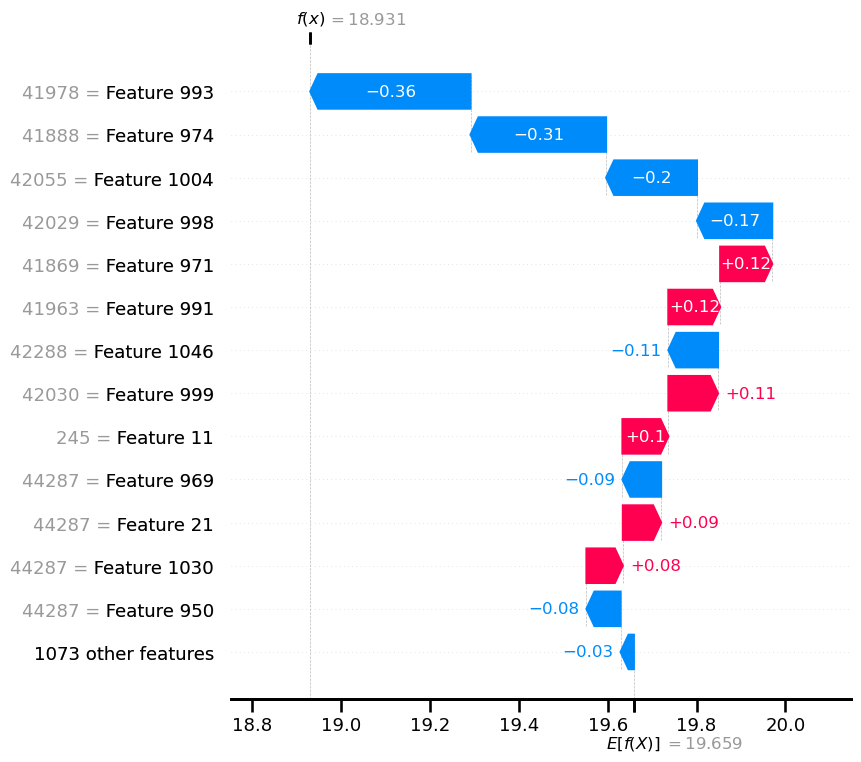

adataX= (4565, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (1815, 1086)
adataX= (1299, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:19<00:07,  3.93s/it]

adataX= (1871, 1086)
adataX= (1345, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:27<00:05,  5.68s/it]

adataX= (2191, 1086)
adataX= (1514, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.07s/it]

adataX= (2027, 1086)
adataX= (1415, 1086)


PermutationExplainer explainer: 6it [00:45,  9.12s/it]                                                                                                                                     


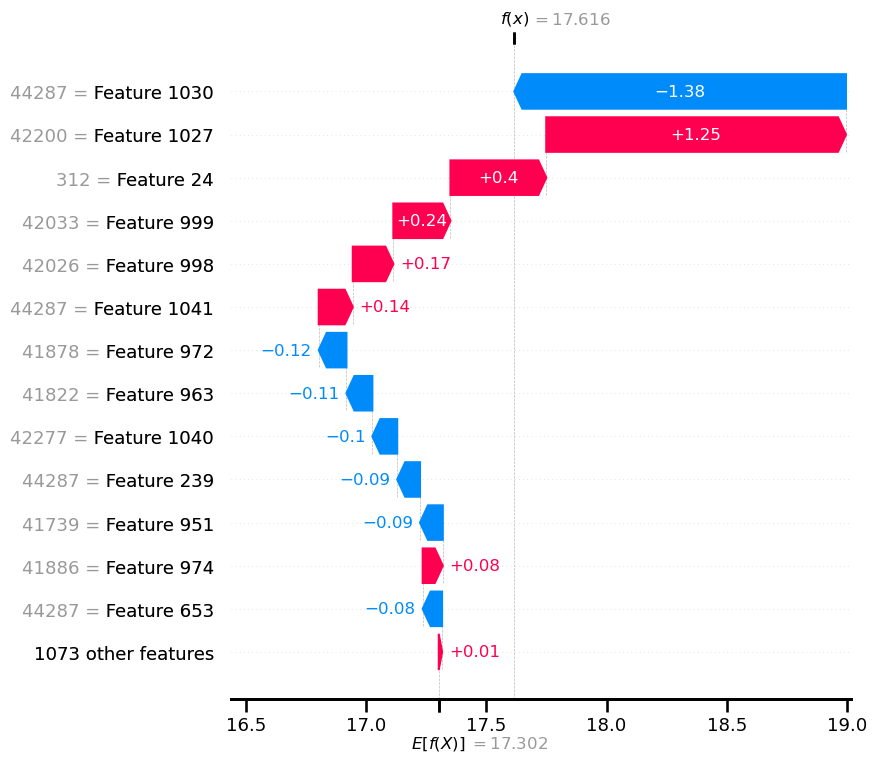

adataX= (951, 1086)
adataX= (951, 1086)
adataX= (951, 1086)
adataX= (951, 1086)
adataX= (951, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (867, 1086)
adataX= (867, 1086)
adataX= (867, 1086)
adataX= (867, 1086)
adataX= (867, 1086)
adataX= (617, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:24<00:12,  6.33s/it]

adataX= (1221, 1086)
adataX= (1221, 1086)
adataX= (1221, 1086)
adataX= (1221, 1086)
adataX= (1221, 1086)
adataX= (789, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:42<00:11, 11.03s/it]

adataX= (1127, 1086)
adataX= (1127, 1086)
adataX= (1127, 1086)
adataX= (1127, 1086)
adataX= (1127, 1086)
adataX= (760, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 13.03s/it]

adataX= (915, 1086)
adataX= (915, 1086)
adataX= (915, 1086)
adataX= (915, 1086)
adataX= (915, 1086)
adataX= (663, 1086)


PermutationExplainer explainer: 6it [01:12, 14.44s/it]                                                                                                                                     


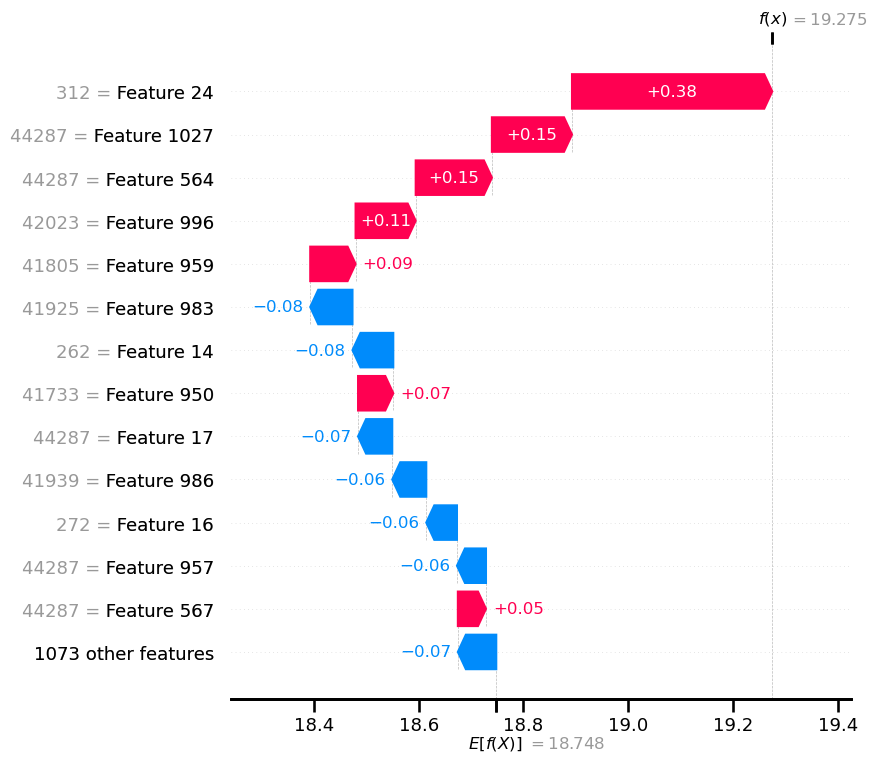

adataX= (3855, 1086)
adataX= (3543, 1086)
adataX= (2176, 1086)


PermutationExplainer explainer:  40%|███████████████████████████████████████████████████▏                                                                            | 2/5 [00:00<?, ?it/s]

adataX= (2681, 1086)
adataX= (1621, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:35<00:05,  5.47s/it]

adataX= (2581, 1086)
adataX= (1572, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  7.59s/it]

adataX= (2557, 1086)
adataX= (1567, 1086)


PermutationExplainer explainer: 6it [00:56, 14.08s/it]                                                                                                                                     


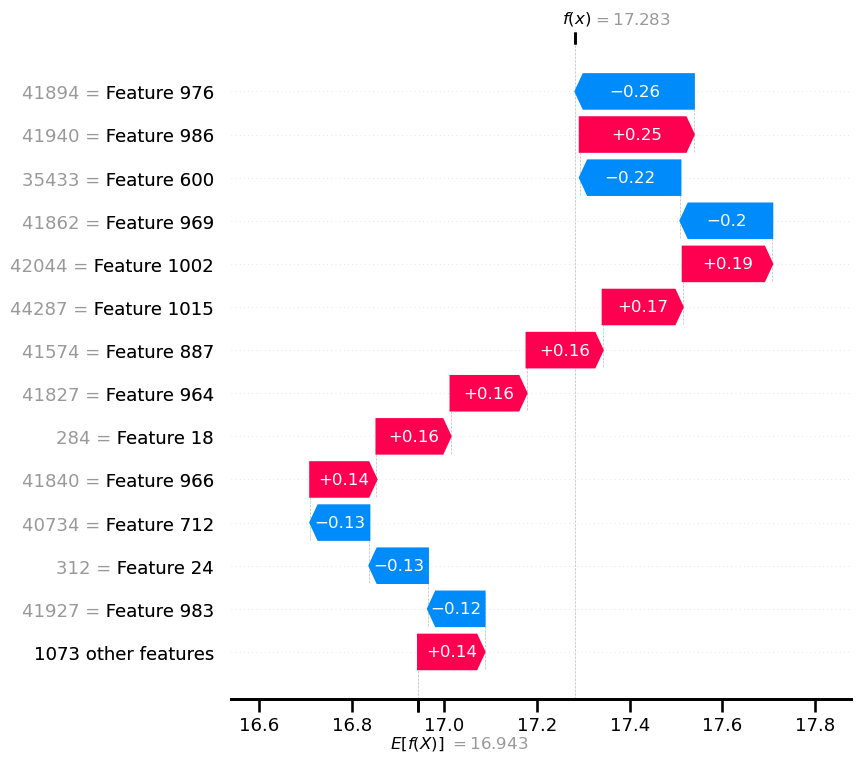

adataX= (823, 1086)
adataX= (823, 1086)
adataX= (823, 1086)
adataX= (823, 1086)
adataX= (823, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (1181, 1086)
adataX= (1181, 1086)
adataX= (1181, 1086)
adataX= (1181, 1086)
adataX= (1181, 1086)
adataX= (736, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:27<00:16,  8.50s/it]

adataX= (765, 1086)
adataX= (765, 1086)
adataX= (765, 1086)
adataX= (765, 1086)
adataX= (765, 1086)
adataX= (574, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:38<00:09,  9.65s/it]

adataX= (771, 1086)
adataX= (771, 1086)
adataX= (771, 1086)
adataX= (771, 1086)
adataX= (771, 1086)
adataX= (567, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.29s/it]

adataX= (833, 1086)
adataX= (833, 1086)
adataX= (833, 1086)
adataX= (833, 1086)
adataX= (833, 1086)
adataX= (591, 1086)


PermutationExplainer explainer: 6it [01:02, 12.46s/it]                                                                                                                                     


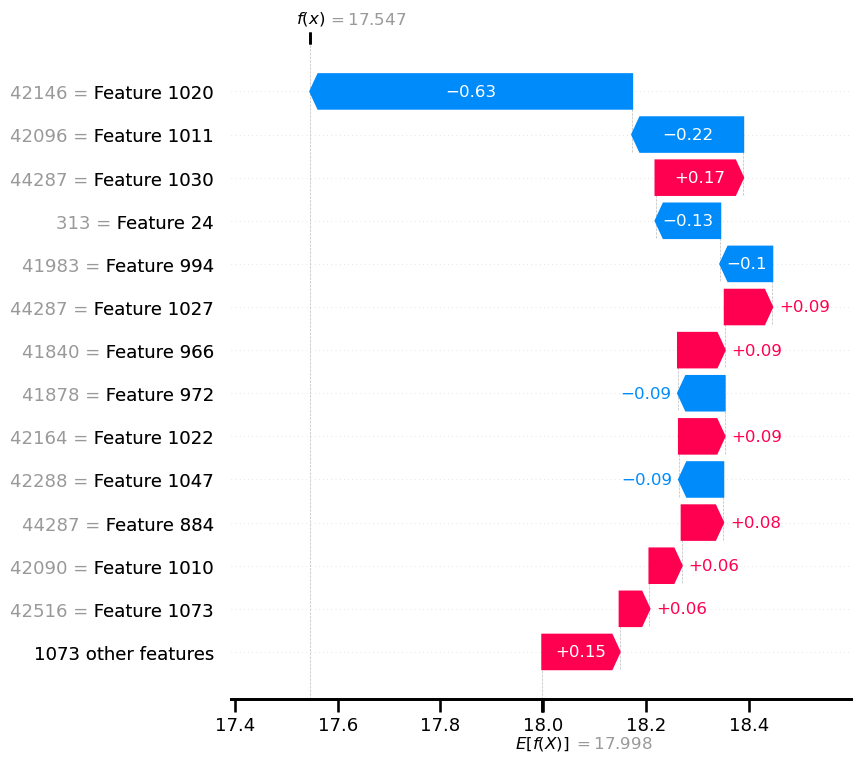

adataX= (3719, 1086)
adataX= (3097, 1086)
adataX= (1909, 1086)


PermutationExplainer explainer:  40%|███████████████████████████████████████████████████▏                                                                            | 2/5 [00:00<?, ?it/s]

adataX= (2795, 1086)
adataX= (1809, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:33<00:05,  5.85s/it]

adataX= (2905, 1086)
adataX= (1822, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  8.43s/it]

adataX= (3853, 1086)
adataX= (2259, 1086)


PermutationExplainer explainer: 6it [01:01, 15.36s/it]                                                                                                                                     


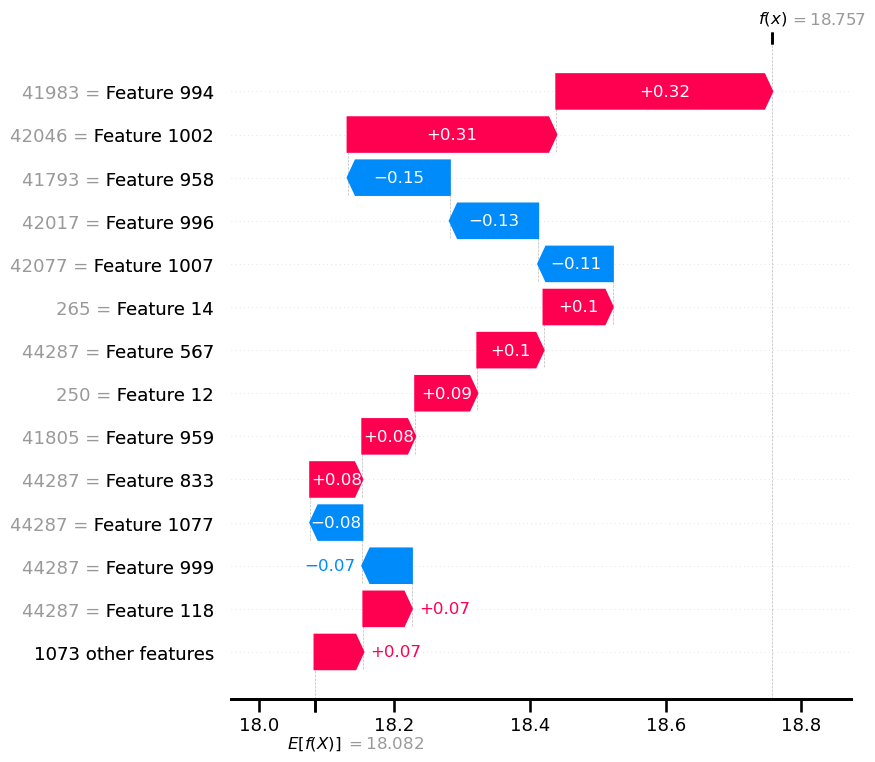

adataX= (627, 1086)
adataX= (627, 1086)
adataX= (627, 1086)
adataX= (627, 1086)
adataX= (627, 1086)
adataX= (627, 1086)
adataX= (627, 1086)
adataX= (627, 1086)
adataX= (627, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (645, 1086)
adataX= (645, 1086)
adataX= (645, 1086)
adataX= (645, 1086)
adataX= (645, 1086)
adataX= (645, 1086)
adataX= (645, 1086)
adataX= (645, 1086)
adataX= (645, 1086)
adataX= (424, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:30<00:15,  7.99s/it]

adataX= (635, 1086)
adataX= (635, 1086)
adataX= (635, 1086)
adataX= (635, 1086)
adataX= (635, 1086)
adataX= (635, 1086)
adataX= (635, 1086)
adataX= (635, 1086)
adataX= (635, 1086)
adataX= (426, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:46<00:11, 11.23s/it]

adataX= (665, 1086)
adataX= (665, 1086)
adataX= (665, 1086)
adataX= (665, 1086)
adataX= (665, 1086)
adataX= (665, 1086)
adataX= (665, 1086)
adataX= (665, 1086)
adataX= (665, 1086)
adataX= (432, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 13.18s/it]

adataX= (617, 1086)
adataX= (617, 1086)
adataX= (617, 1086)
adataX= (617, 1086)
adataX= (617, 1086)
adataX= (617, 1086)
adataX= (617, 1086)
adataX= (617, 1086)
adataX= (617, 1086)
adataX= (424, 1086)


PermutationExplainer explainer: 6it [01:18, 15.60s/it]                                                                                                                                     


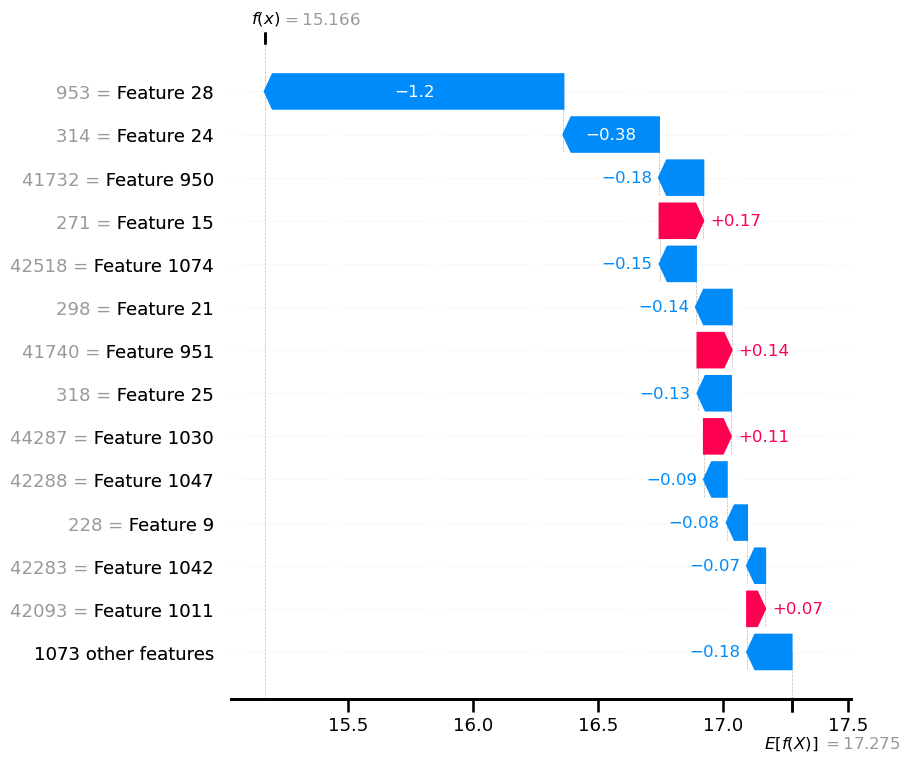

adataX= (631, 1086)
adataX= (631, 1086)
adataX= (631, 1086)
adataX= (631, 1086)
adataX= (631, 1086)
adataX= (631, 1086)
adataX= (631, 1086)
adataX= (631, 1086)
adataX= (631, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (603, 1086)
adataX= (603, 1086)
adataX= (603, 1086)
adataX= (603, 1086)
adataX= (603, 1086)
adataX= (603, 1086)
adataX= (603, 1086)
adataX= (603, 1086)
adataX= (603, 1086)
adataX= (411, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:29<00:15,  7.52s/it]

adataX= (677, 1086)
adataX= (677, 1086)
adataX= (677, 1086)
adataX= (677, 1086)
adataX= (677, 1086)
adataX= (677, 1086)
adataX= (677, 1086)
adataX= (677, 1086)
adataX= (677, 1086)
adataX= (442, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:46<00:11, 11.38s/it]

adataX= (639, 1086)
adataX= (639, 1086)
adataX= (639, 1086)
adataX= (639, 1086)
adataX= (639, 1086)
adataX= (639, 1086)
adataX= (639, 1086)
adataX= (639, 1086)
adataX= (639, 1086)
adataX= (431, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 13.06s/it]

adataX= (619, 1086)
adataX= (619, 1086)
adataX= (619, 1086)
adataX= (619, 1086)
adataX= (619, 1086)
adataX= (619, 1086)
adataX= (619, 1086)
adataX= (619, 1086)
adataX= (619, 1086)
adataX= (424, 1086)


PermutationExplainer explainer: 6it [01:17, 15.55s/it]                                                                                                                                     


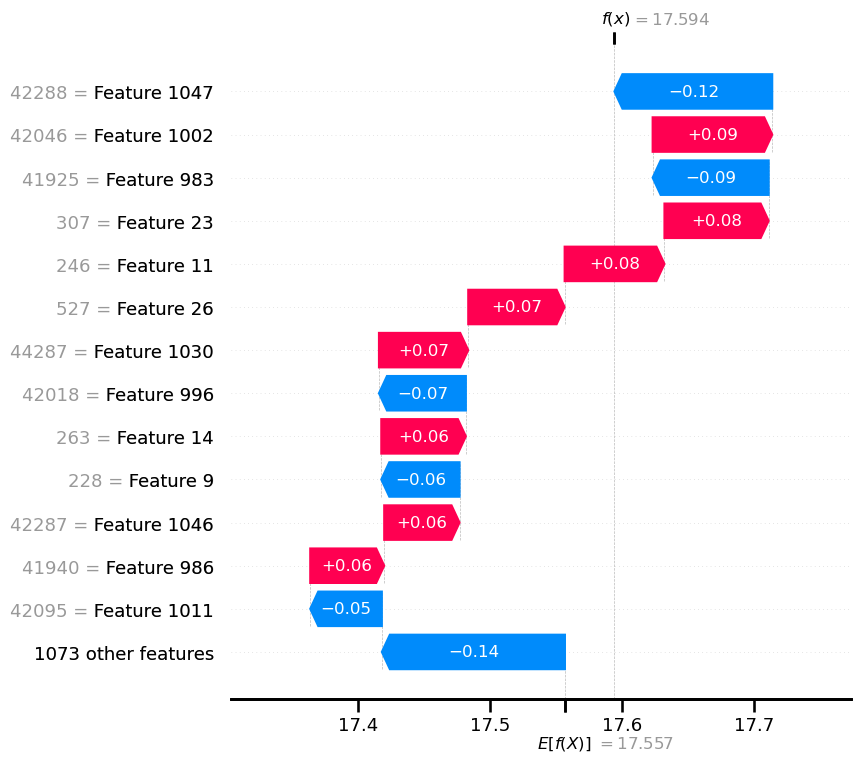

adataX= (1615, 1086)
adataX= (1615, 1086)
adataX= (1615, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (1069, 1086)
adataX= (1069, 1086)
adataX= (1069, 1086)
adataX= (829, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:22<00:10,  5.17s/it]

adataX= (1361, 1086)
adataX= (1361, 1086)
adataX= (1361, 1086)
adataX= (969, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:35<00:08,  8.41s/it]

adataX= (1099, 1086)
adataX= (1099, 1086)
adataX= (1099, 1086)
adataX= (840, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.22s/it]

adataX= (1413, 1086)
adataX= (1413, 1086)
adataX= (1413, 1086)
adataX= (980, 1086)


PermutationExplainer explainer: 6it [00:59, 11.92s/it]                                                                                                                                     


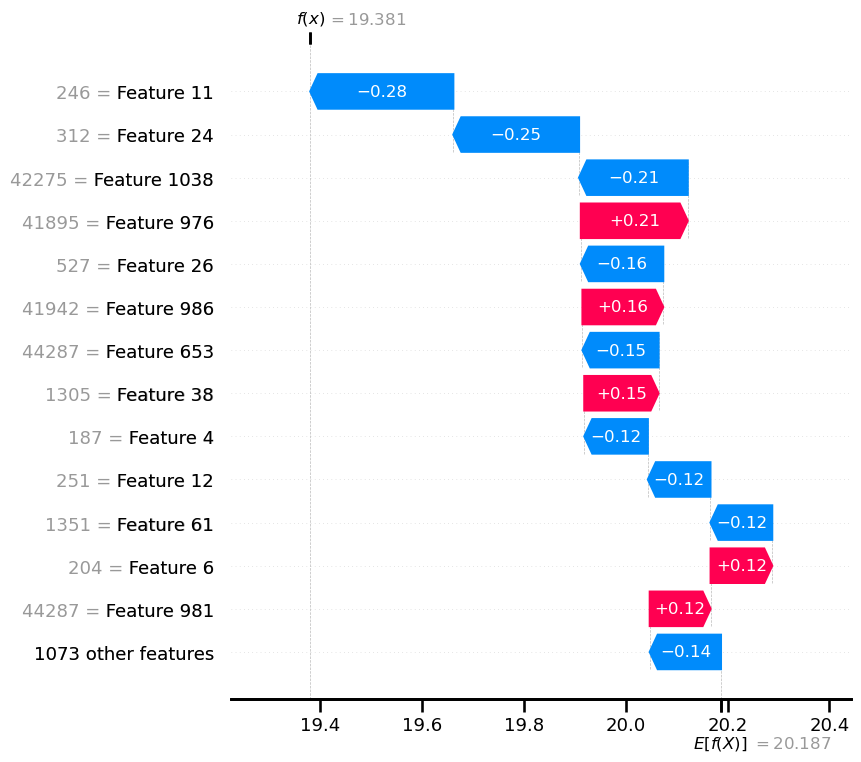

adataX= (867, 1086)
adataX= (867, 1086)
adataX= (867, 1086)
adataX= (867, 1086)
adataX= (867, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (823, 1086)
adataX= (823, 1086)
adataX= (823, 1086)
adataX= (823, 1086)
adataX= (823, 1086)
adataX= (600, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:23<00:12,  6.03s/it]

adataX= (1349, 1086)
adataX= (1349, 1086)
adataX= (1349, 1086)
adataX= (1349, 1086)
adataX= (1349, 1086)
adataX= (808, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:42<00:11, 11.55s/it]

adataX= (865, 1086)
adataX= (865, 1086)
adataX= (865, 1086)
adataX= (865, 1086)
adataX= (865, 1086)
adataX= (611, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.95s/it]

adataX= (837, 1086)
adataX= (837, 1086)
adataX= (837, 1086)
adataX= (837, 1086)
adataX= (837, 1086)
adataX= (616, 1086)


PermutationExplainer explainer: 6it [01:07, 13.47s/it]                                                                                                                                     


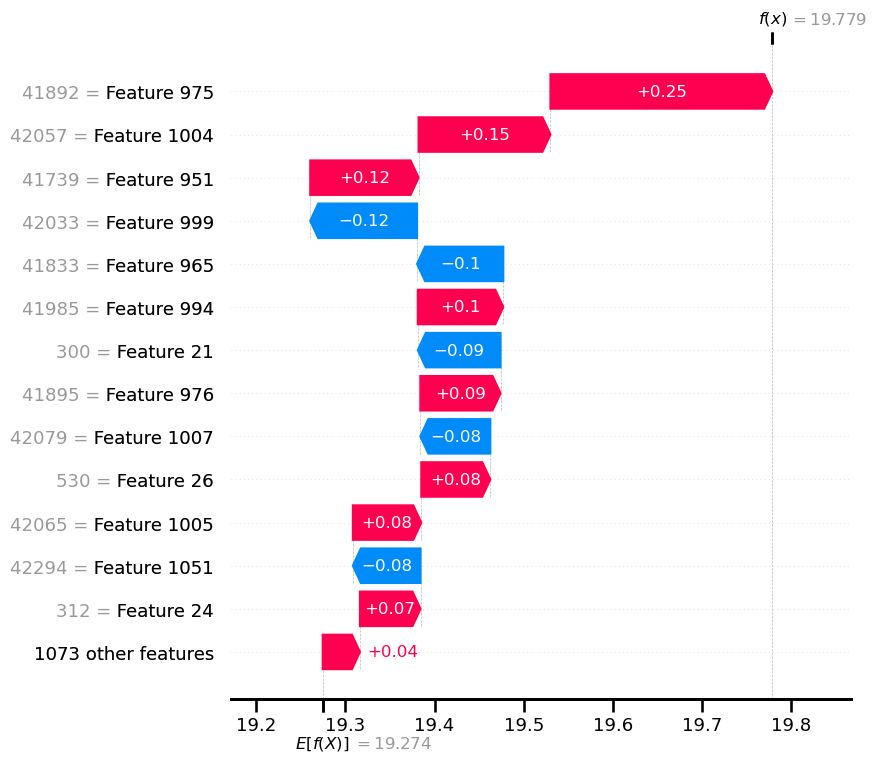

adataX= (889, 1086)
adataX= (889, 1086)
adataX= (889, 1086)
adataX= (889, 1086)
adataX= (889, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (815, 1086)
adataX= (815, 1086)
adataX= (815, 1086)
adataX= (815, 1086)
adataX= (815, 1086)
adataX= (596, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:23<00:11,  5.97s/it]

adataX= (765, 1086)
adataX= (765, 1086)
adataX= (765, 1086)
adataX= (765, 1086)
adataX= (765, 1086)
adataX= (571, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:34<00:08,  8.18s/it]

adataX= (1197, 1086)
adataX= (1197, 1086)
adataX= (1197, 1086)
adataX= (1197, 1086)
adataX= (1197, 1086)
adataX= (760, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 11.56s/it]

adataX= (775, 1086)
adataX= (775, 1086)
adataX= (775, 1086)
adataX= (775, 1086)
adataX= (775, 1086)
adataX= (563, 1086)


PermutationExplainer explainer: 6it [01:03, 12.64s/it]                                                                                                                                     


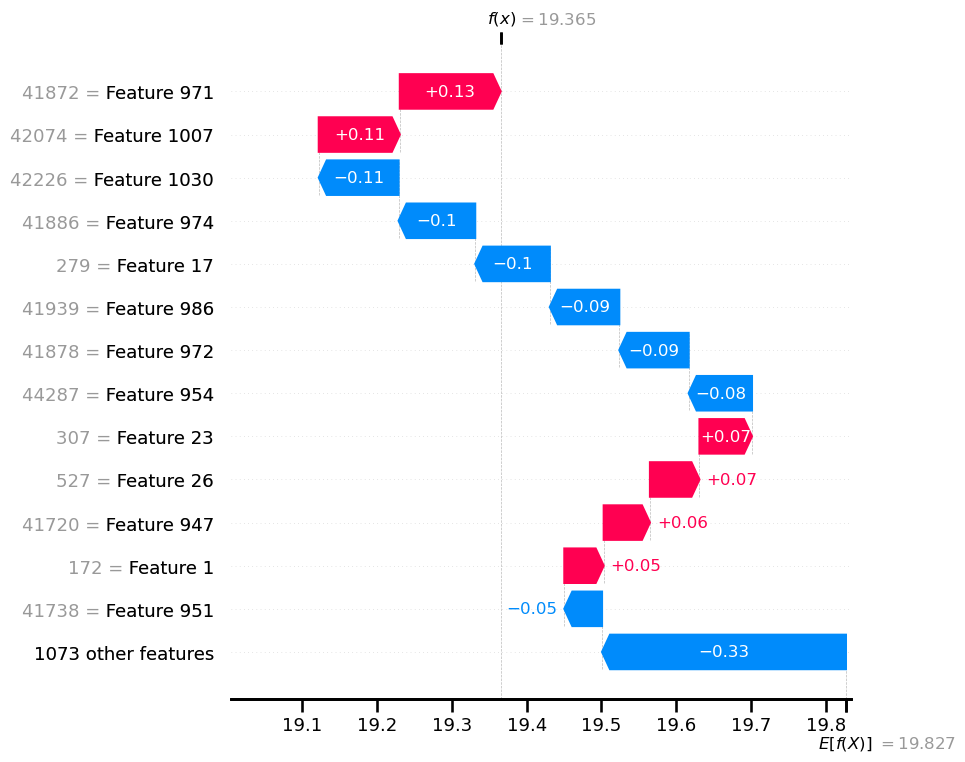

adataX= (1061, 1086)
adataX= (1061, 1086)
adataX= (1061, 1086)
adataX= (1061, 1086)
adataX= (1061, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (1129, 1086)
adataX= (1129, 1086)
adataX= (1129, 1086)
adataX= (1129, 1086)
adataX= (1129, 1086)
adataX= (728, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:29<00:16,  8.16s/it]

adataX= (871, 1086)
adataX= (871, 1086)
adataX= (871, 1086)
adataX= (871, 1086)
adataX= (871, 1086)
adataX= (617, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:42<00:10, 10.07s/it]

adataX= (869, 1086)
adataX= (869, 1086)
adataX= (869, 1086)
adataX= (869, 1086)
adataX= (869, 1086)
adataX= (625, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.07s/it]

adataX= (899, 1086)
adataX= (899, 1086)
adataX= (899, 1086)
adataX= (899, 1086)
adataX= (899, 1086)
adataX= (633, 1086)


PermutationExplainer explainer: 6it [01:08, 13.71s/it]                                                                                                                                     


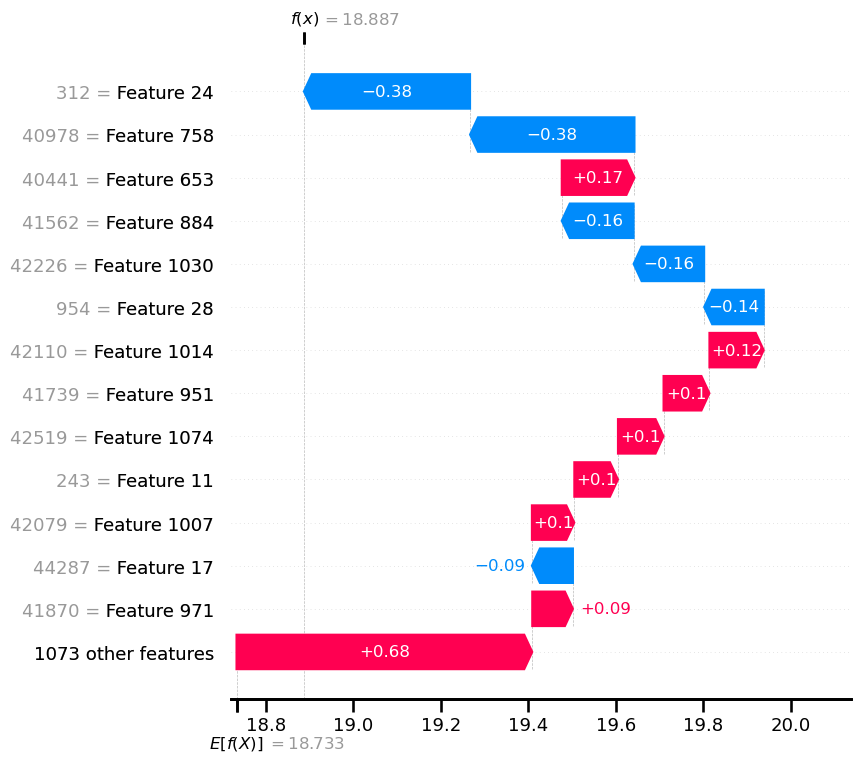

adataX= (877, 1086)
adataX= (877, 1086)
adataX= (877, 1086)
adataX= (877, 1086)
adataX= (877, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (849, 1086)
adataX= (849, 1086)
adataX= (849, 1086)
adataX= (849, 1086)
adataX= (849, 1086)
adataX= (615, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:23<00:12,  6.23s/it]

adataX= (951, 1086)
adataX= (951, 1086)
adataX= (951, 1086)
adataX= (951, 1086)
adataX= (951, 1086)
adataX= (658, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:37<00:09,  9.41s/it]

adataX= (1167, 1086)
adataX= (1167, 1086)
adataX= (1167, 1086)
adataX= (1167, 1086)
adataX= (1167, 1086)
adataX= (760, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 12.20s/it]

adataX= (1121, 1086)
adataX= (1121, 1086)
adataX= (1121, 1086)
adataX= (1121, 1086)
adataX= (1121, 1086)
adataX= (764, 1086)


PermutationExplainer explainer: 6it [01:10, 14.15s/it]                                                                                                                                     


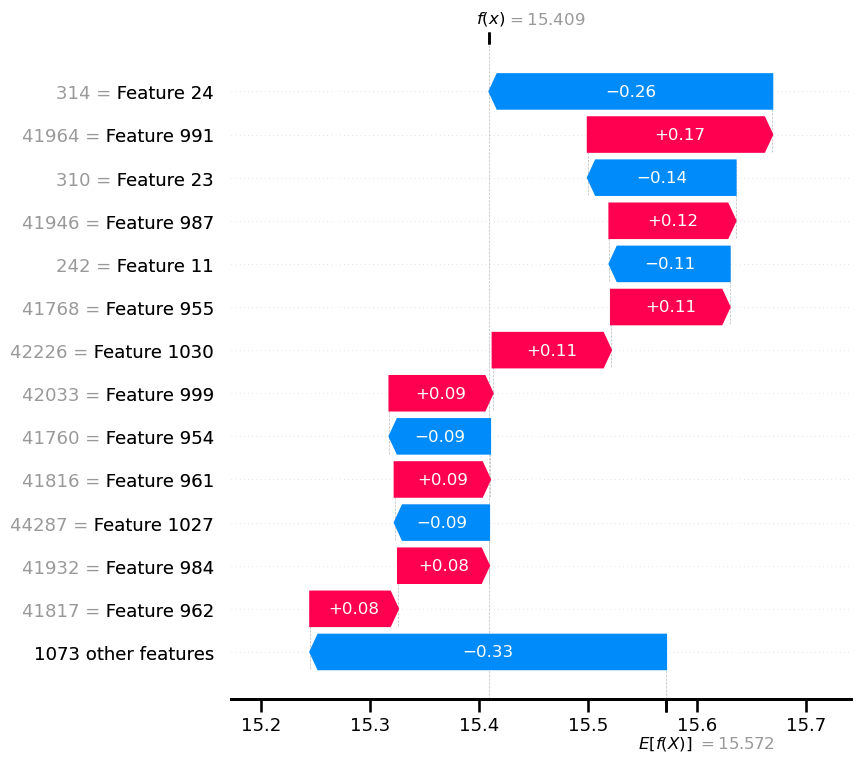

adataX= (805, 1086)
adataX= (805, 1086)
adataX= (805, 1086)
adataX= (805, 1086)
adataX= (805, 1086)


PermutationExplainer explainer:  20%|█████████████████████████▌                                                                                                      | 1/5 [00:00<?, ?it/s]

adataX= (809, 1086)
adataX= (809, 1086)
adataX= (809, 1086)
adataX= (809, 1086)
adataX= (809, 1086)
adataX= (574, 1086)


PermutationExplainer explainer:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:22<00:11,  5.92s/it]

adataX= (1209, 1086)
adataX= (1209, 1086)
adataX= (1209, 1086)
adataX= (1209, 1086)
adataX= (1209, 1086)
adataX= (758, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:39<00:10, 10.72s/it]

adataX= (817, 1086)
adataX= (817, 1086)
adataX= (817, 1086)
adataX= (817, 1086)
adataX= (817, 1086)
adataX= (586, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 11.19s/it]

adataX= (1133, 1086)
adataX= (1133, 1086)
adataX= (1133, 1086)
adataX= (1133, 1086)
adataX= (1133, 1086)
adataX= (745, 1086)


PermutationExplainer explainer: 6it [01:07, 13.60s/it]                                                                                                                                     


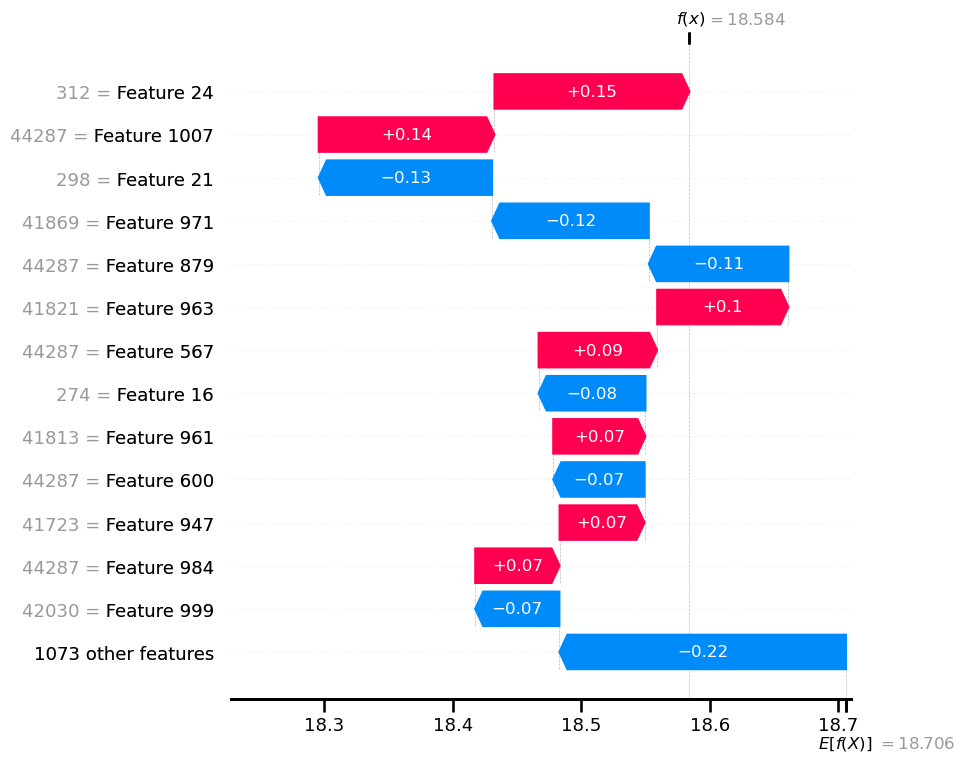

adataX= (1683, 1086)
adataX= (1679, 1086)
adataX= (1183, 1086)


PermutationExplainer explainer:  40%|███████████████████████████████████████████████████▏                                                                            | 2/5 [00:00<?, ?it/s]

adataX= (1715, 1086)
adataX= (1225, 1086)


PermutationExplainer explainer:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:19<00:03,  3.75s/it]

adataX= (4323, 1086)
adataX= (2480, 1086)


PermutationExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  9.41s/it]

adataX= (2073, 1086)
adataX= (1430, 1086)


PermutationExplainer explainer: 6it [00:45, 11.34s/it]                                                                                                                                     


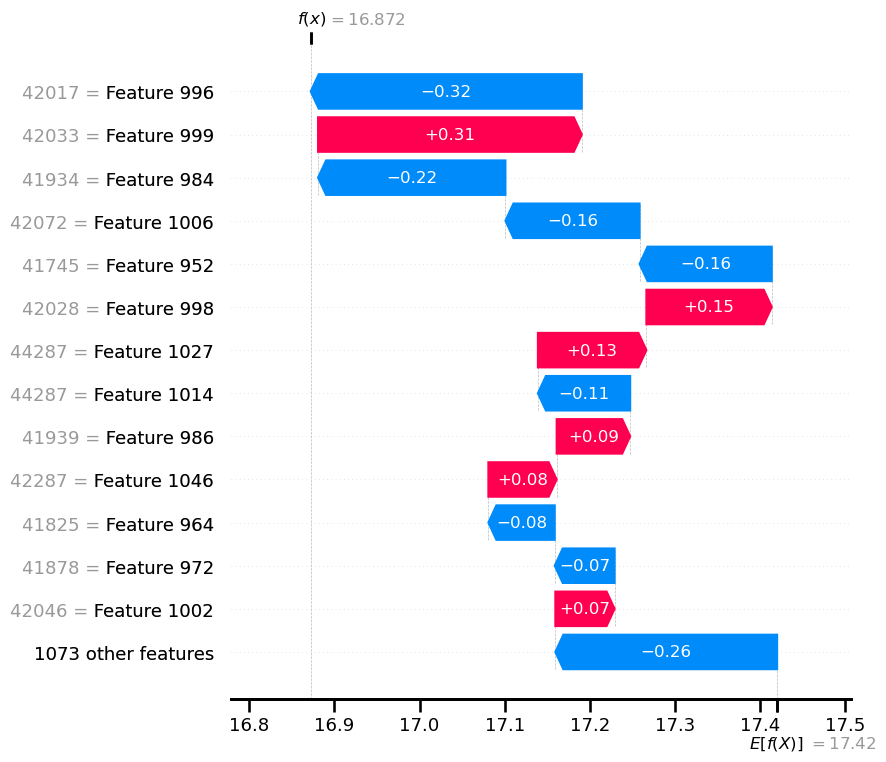

In [366]:
# 计算shapley值, 重要不要删
import shap
import torch
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import re

# 设置随机种子
np.random.seed(42)  

meanings = [
    "hypertension",
    #"high cholesterol",
    "asthma",
    #"osteoarthritis",
    #"hayfever/allergic rhinitis",
    #"depression",
    #"hypothyroidism/myxoedema",
    #"gastro-oesophageal reflux (gord) / gastric reflux",
    "diabetes"
]


meanings = [
    "breast cancer",
    "cin/pre-cancer cells cervix",
    "hayfever/allergic rhinitis",
    "prostate cancer",
    "hypothyroidism/myxoedema",
    "malignant melanoma",
    "malabsorption/coeliac disease",
    "basal cell carcinoma",
    "high cholesterol",
    "osteoarthritis",
    "depression",
    "diabetes",
    "inguinal hernia",
    "migraine",
    "cervical cancer"
]


# 初始化结果 DataFrame
out_f1_df = pd.DataFrame(columns=['trait', 'value', 'meaning', 'token_id', 
                                  'TP', 'FN', 'FP', 'TN', 'F1', 'Total'])
embedding_df = pd.DataFrame(columns=['Prediction', 'Target', 'Embedding'])

# "Diet and alcohol summary", "Lifestyle"
# 过滤掉不需要的特征
#keep_col = ["Diet and alcohol summary", "Lifestyle", "Education and employment"  ]
keep_col = traits_df['category_name']
keep_col = ["Diet and alcohol summary", "Lifestyle" ]
keep_traits_df = traits_df[((traits_df['category_name'].isin(keep_col)) |
                            traits_df['field_id'].isin([20002, 20001]))]

test_df = data_df.iloc[:450000, :]

# change adata value to combine 'col_value' style
# 筛选出想保留的特征类别
test_df = test_df.fillna(vocab["<pad>"])
# 删除完全是 pad_value 的列
#test_df = test_df.loc[:, ~(test_df == pad_value).all(axis=0)]
#去除空值超过50%的行
#pad_ratio = (test_df == pad_value).mean(axis=1)  
#test_df = test_df[pad_ratio <= 0.5]  
keep_col_idx = [v  for v in test_df.columns if int(re.search(r'd(\d+)-', v).group(1)) in keep_traits_df['field_id'].values]
test_df = test_df.loc[:, keep_col_idx]



# 将 meanings 转换为字典索引以提高效率
meaning_to_traits = {meaning: traits_df[traits_df['meaning'] == meaning] for meaning in meanings}

for meaning, sel_traits_df in meaning_to_traits.items():
    diseases_df = sel_traits_df['token_id']

    
    # 判断有病的患者行
    contains_disease_indices = np.where(np.any(test_df.values == diseases_df[diseases_df % 2 == 0].values, axis=1))[0]
    
    # 判断没病的患者行
    not_contains_disease_indices = np.where(np.any(test_df.values == diseases_df[diseases_df % 2 == 1].values, axis=1))[0]
    
    # 随机采样阴性样本
    sampled_not_contains_disease_indices = np.random.choice(
        not_contains_disease_indices, size=contains_disease_indices.shape[0], replace=False
    )
    
    # 合并有病和采样的无病样本索引
    selected_indices = np.concatenate((contains_disease_indices, sampled_not_contains_disease_indices))
    
  
    adata = sc.AnnData(test_df.values[selected_indices].copy())

    # 清空 GPU 缓存
    torch.cuda.empty_cache()

    device = 'cuda:3'
    
    # 定义模型预测函数
    def model_predict(adataX):
        # 使用该函数对 all_counts 进行替换，并覆盖原数组
        print('adataX=', adataX.shape)
        trait_ids = vectorized_replace(adataX)
        
        input_layer_key = None
        individualtypes_labels = np.array(range(adata.shape[0]))
        train_data = adataX
        
        max_seq_len = 3000
        
        tokenized_train = tokenize_and_pad_batch(
            train_data,
            trait_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=False,  # append <cls> token at the beginning
            include_zero_trait=True,
        )
        
        input_trait_ids_train = tokenized_train["traits"].to(device)
        values = tokenized_train["values"].to(device)
        #print('values=', values, values.shape)

        input_values_train = values.clone()
    
        # 用 diseases 和 pad_traits 进行掩码
        diseases_values_tensor = torch.tensor(diseases_df.values, dtype=input_values_train.dtype, device=values.device)
        diseases_token_id_tensor = torch.tensor(traits_df[traits_df['field_id'].isin([20002, 20001])]['token_id'].values, dtype=input_values_train.dtype, device=values.device)
        mask_value_tensor = torch.tensor(mask_value, dtype=input_values_train.dtype, device=values.device)
        pad_value_tensor = torch.tensor(pad_value, dtype=input_values_train.dtype, device=values.device)
    
        # 把疾病部分mask住，把其余不需要作为输入的pad住
        input_values_train = torch.where(torch.isin(input_values_train, diseases_values_tensor), mask_value_tensor, input_values_train)
        input_values_train = torch.where(torch.isin(input_values_train, diseases_token_id_tensor), pad_value_tensor, input_values_train)

        # 生成数据集和 DataLoader  #####
        dataset = SeqDataset({"trait_ids": input_trait_ids_train, "values": input_values_train,
                              "target_values": values,
                              "batch_labels": torch.zeros(input_trait_ids_train.shape[0]), 
                              "individualtype_labels": torch.zeros(input_trait_ids_train.shape[0])})
        
        del diseases_values_tensor, input_values_train  ######### 
    
        
        train_loader = DataLoader(dataset, batch_size=20, shuffle=False, drop_last=False, num_workers=0, pin_memory=False)
        predictions, targets = [], []
        model.to(device)
        torch.cuda.empty_cache()
        
        # 处理每个批次
        
        for batch_data in train_loader:
            batch_data = {k: v.to(device) for k, v in batch_data.items()}
            
            with torch.no_grad():
                transformer_output = model._encode(batch_data["trait_ids"], batch_data["values"], 
                                                   batch_data["trait_ids"].eq(vocab[pad_token]), batch_data["batch_labels"])
                mlm_output = model.combine_decoder(transformer_output)
                decoded_embs = mlm_output[np.isin(batch_data["target_values"].cpu().numpy(), diseases_df.values)]
                
                # 提取预测值和目标值 diseases_df.values] = array([1602, 1603]) 代表阳和阴
                predictions += list(decoded_embs[:, diseases_df.values].cpu().numpy())
        return np.array(predictions)            

    #values = tokenized_train["values"][:,:].cpu().numpy()
    adataX = adata.X.copy()
    # 使用 KernelExplainer 计算 SHAP 值
    explainer = shap.explainers.Permutation(model_predict, adataX[:5])
    #algorithm“auto”, “permutation”, “partition”, “tree”, or “linear”
    # 计算 SHAP 值，使用部分数据分析
    shap_values = explainer(adataX[:], max_evals=2313)
    
    # 绘制和保存 SHAP summary plot
    # 替换 meaning 中的不合法字符
    safe_meaning = re.sub(r'[^\w]', '_', meaning)  # 将所有非字母、数字、下划线字符替换为下划线

    # 1. 绘制 waterfall plot 并保存
    plt.figure()
    shap_values_for_class_1 = shap_values[..., 0]  # 提取类别 1 的 Shapley 值
    shap.plots.waterfall(shap_values_for_class_1[0], max_display=14)
    plt.savefig(f'APP3_{safe_meaning}_shap_waterfall.svg', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. 绘制 SHAP summary plot
    plt.figure()
    shap.summary_plot(shap_values[..., 0], features=adataX[:], show=False)  # show=False 防止直接显示
    plt.savefig(f'APP3_{safe_meaning}_shap_summary.svg', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. 绘制 summary plot 展示所有特征的重要性（柱状图）
    plt.figure()
    shap.summary_plot(shap_values[..., 0], features=adataX[:], plot_type="bar", show=False)
    plt.savefig(f'APP3_{safe_meaning}_shap_summary_bar.svg', dpi=300, bbox_inches='tight')
    plt.close()

